## Load and apply inference models
This notebook loads trained inference models from the outputs of `cmass.infer.train`, plots their prediction performance, and applies them to new test data.

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os
from os.path import join
import pickle
import json
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('../../style.mcstyle')   # noqa
import numpy as np
import torch
import seaborn as sns
import pandas as pd
import warnings
from tqdm import tqdm

# Suppress warnings
warnings.filterwarnings('ignore')

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is not available. Using CPU.


## Cut up abacus simulations

In [9]:
wdir = '/anvil/scratch/x-mho1/cmass-ili'
abadir = join(wdir, 'abacus', 'custom', 'L2000-N256')
a = '0.666667'

lhid = os.listdir(abadir)
lhid = lhid[0]
filename = join(abadir, lhid, 'halos.h5')
with h5py.File(filename, 'r') as f:
    mass, pos, vel = f[a]['mass'][()], f[a]['pos'][()], f[a]['vel'][()]

Text(0.5, 0, 'Mass [h^-1 M_sun]')

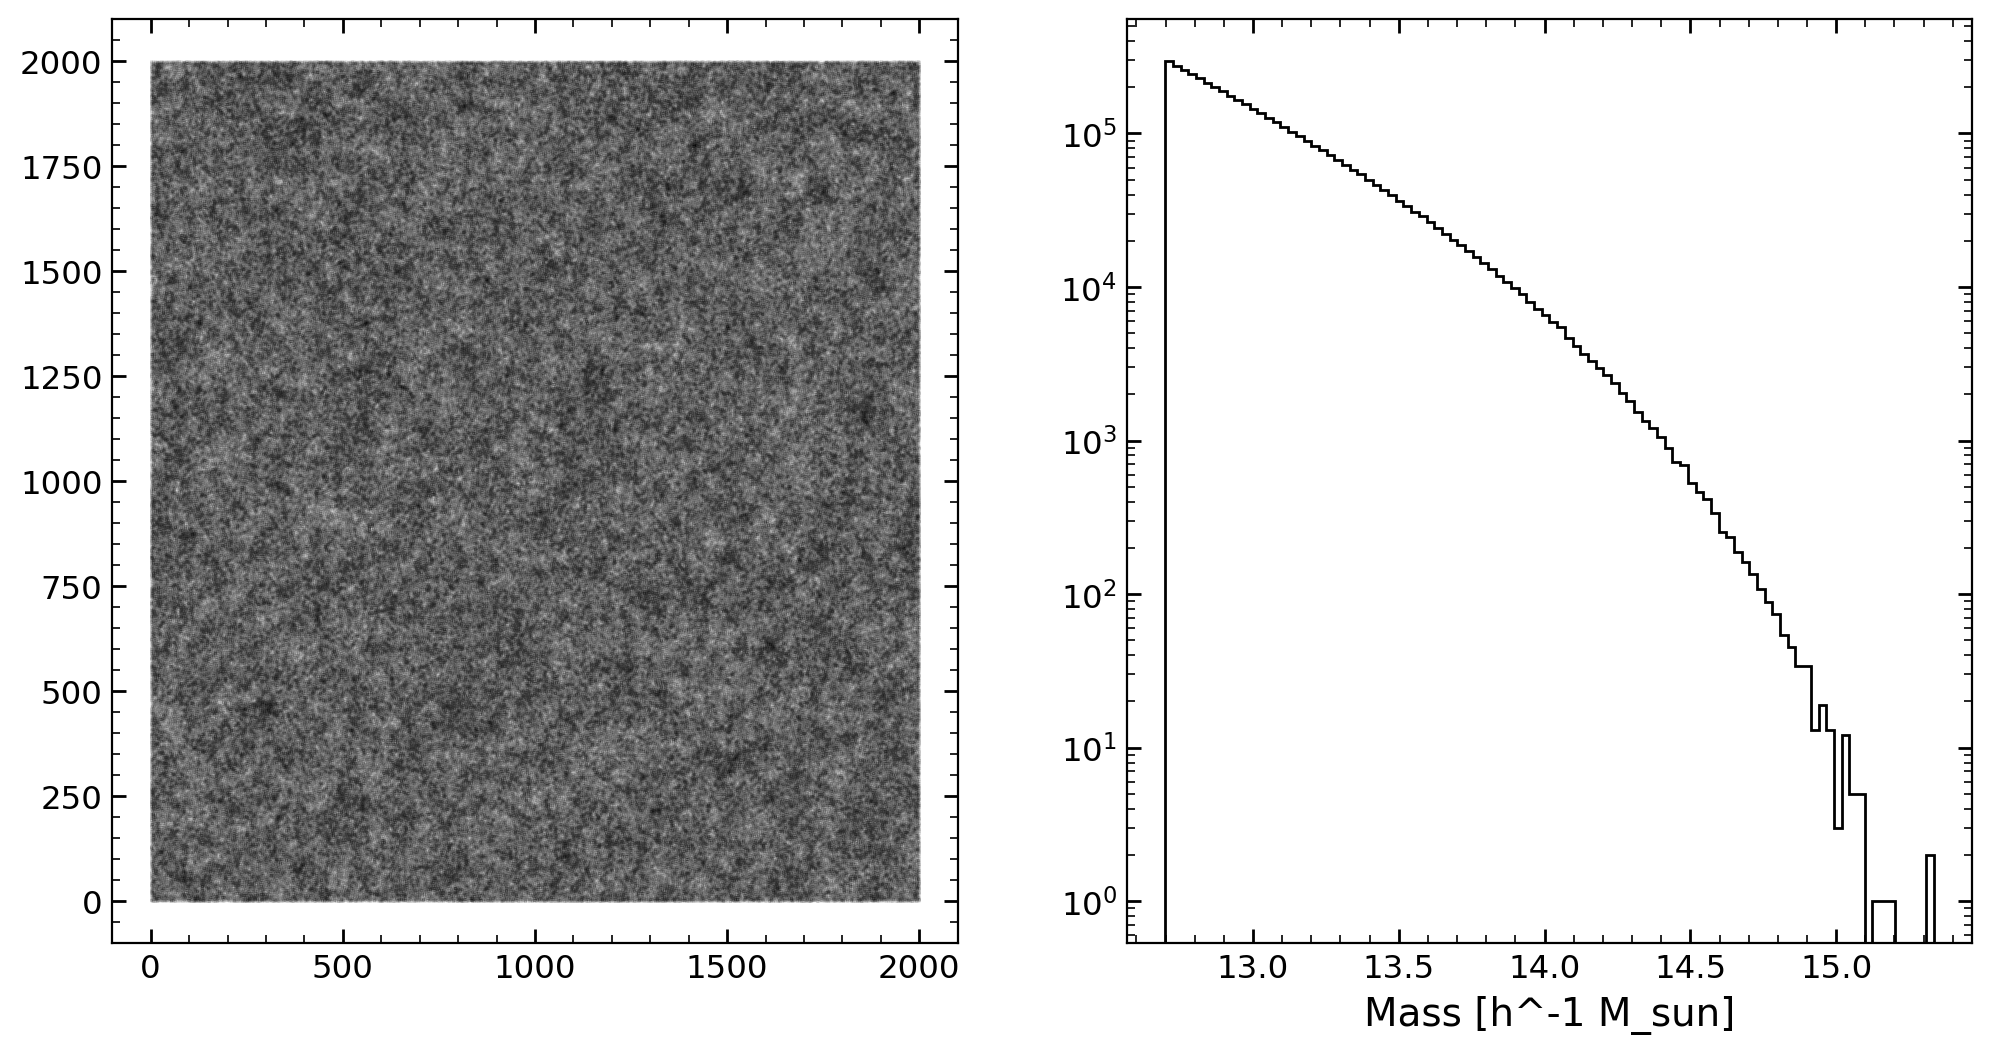

In [10]:
f, axs = plt.subplots(1, 2, figsize=(12, 6))
ax = axs[0]
ax.plot(pos[:, 0], pos[:, 1], 'k.', markersize=0.1, alpha=0.1)

ax = axs[1]
ax.semilogy()
ax.hist(mass, bins=100, histtype='step', color='k')
ax.set_xlabel('Mass [h^-1 M_sun]')

In [11]:
files = os.listdir(abadir)
outdir = join(wdir, 'abacus1gpch', 'custom', 'L1000-N128')

for lhid in files:
    filename = join(abadir, lhid, 'halos.h5')
    with h5py.File(filename, 'r') as f:
        mass, pos, vel = f[a]['mass'][()], f[a]['pos'][()], f[a]['vel'][()]
        print(f'Loaded {lhid} with {len(mass)} halos')

    # randomly shift
    pos += np.random.rand(1, 3) * 2000
    pos %= 2000

    # zero-out velocities
    vel -= vel.mean(axis=0)

    # Mask out corner
    mask = np.all((pos > 0) & (pos < 1000), axis=1)
    mass = mass[mask]
    pos = pos[mask]
    vel = vel[mask]
    print(f'Filtered {lhid} to {len(mass)} halos')

    # Save the data to a new file
    outfilename = join(outdir, lhid, 'halos.h5')
    os.makedirs(join(outdir, lhid), exist_ok=True)
    with h5py.File(outfilename, 'w') as f:
        g = f.create_group(a)
        g.create_dataset('mass', data=mass)
        g.create_dataset('pos', data=pos)
        g.create_dataset('vel', data=vel)
    print(f'Saved {lhid} to {outfilename}')

Loaded 69 with 4395091 halos
Filtered 69 to 549834 halos
Saved 69 to /anvil/scratch/x-mho1/cmass-ili/abacus1gpch/custom/L1000-N128/69/halos.h5
Loaded 34 with 4522813 halos
Filtered 34 to 567718 halos
Saved 34 to /anvil/scratch/x-mho1/cmass-ili/abacus1gpch/custom/L1000-N128/34/halos.h5
Loaded 37 with 5763416 halos
Filtered 37 to 723334 halos
Saved 37 to /anvil/scratch/x-mho1/cmass-ili/abacus1gpch/custom/L1000-N128/37/halos.h5
Loaded 85 with 6147510 halos


Filtered 85 to 768092 halos
Saved 85 to /anvil/scratch/x-mho1/cmass-ili/abacus1gpch/custom/L1000-N128/85/halos.h5
Loaded 80 with 4126542 halos
Filtered 80 to 512972 halos
Saved 80 to /anvil/scratch/x-mho1/cmass-ili/abacus1gpch/custom/L1000-N128/80/halos.h5
Loaded 88 with 5493467 halos
Filtered 88 to 685282 halos
Saved 88 to /anvil/scratch/x-mho1/cmass-ili/abacus1gpch/custom/L1000-N128/88/halos.h5
Loaded 107 with 6960886 halos
Filtered 107 to 867877 halos
Saved 107 to /anvil/scratch/x-mho1/cmass-ili/abacus1gpch/custom/L1000-N128/107/halos.h5
Loaded 83 with 5120460 halos
Filtered 83 to 639494 halos
Saved 83 to /anvil/scratch/x-mho1/cmass-ili/abacus1gpch/custom/L1000-N128/83/halos.h5
Loaded 103 with 5982761 halos
Filtered 103 to 748699 halos
Saved 103 to /anvil/scratch/x-mho1/cmass-ili/abacus1gpch/custom/L1000-N128/103/halos.h5
Loaded 53 with 5974764 halos
Filtered 53 to 749373 halos
Saved 53 to /anvil/scratch/x-mho1/cmass-ili/abacus1gpch/custom/L1000-N128/53/halos.h5
Loaded 7 with 462698

In [15]:
from omegaconf import OmegaConf
from copy import deepcopy
files = os.listdir(abadir)
baseconfig = OmegaConf.load(
    '/anvil/scratch/x-mho1/cmass-ili/abacus/custom/L2000-N256/0/config.yaml')
outdir = '/anvil/scratch/x-mho1/cmass-ili/abacus/custom/L2000-N256'
cosmofile = '/home/x-mho1/git/ltu-cmass/params/abacus_custom_cosmologies.txt'

for lhid in files:
    # Load the cosmology
    with open(cosmofile, 'r') as f:
        cosmo = f.readlines()[int(lhid)]
    cosmo = [float(x) for x in cosmo.split()]

    config = deepcopy(baseconfig)
    config.sim = 'custom'
    config.nbody.lhid = int(lhid)
    config.nbody.cosmo = cosmo

    # Save the data to a new file
    outfilename = join(outdir, lhid, 'config.yaml')

    with open(outfilename, 'w') as f:
        OmegaConf.save(config, f)
    print(f'Saved {lhid} to {outfilename}')

Saved 69 to /anvil/scratch/x-mho1/cmass-ili/abacus/custom/L2000-N256/69/config.yaml
Saved 34 to /anvil/scratch/x-mho1/cmass-ili/abacus/custom/L2000-N256/34/config.yaml
Saved 37 to /anvil/scratch/x-mho1/cmass-ili/abacus/custom/L2000-N256/37/config.yaml
Saved 85 to /anvil/scratch/x-mho1/cmass-ili/abacus/custom/L2000-N256/85/config.yaml
Saved 80 to /anvil/scratch/x-mho1/cmass-ili/abacus/custom/L2000-N256/80/config.yaml
Saved 88 to /anvil/scratch/x-mho1/cmass-ili/abacus/custom/L2000-N256/88/config.yaml
Saved 107 to /anvil/scratch/x-mho1/cmass-ili/abacus/custom/L2000-N256/107/config.yaml
Saved 83 to /anvil/scratch/x-mho1/cmass-ili/abacus/custom/L2000-N256/83/config.yaml
Saved 103 to /anvil/scratch/x-mho1/cmass-ili/abacus/custom/L2000-N256/103/config.yaml
Saved 53 to /anvil/scratch/x-mho1/cmass-ili/abacus/custom/L2000-N256/53/config.yaml
Saved 7 to /anvil/scratch/x-mho1/cmass-ili/abacus/custom/L2000-N256/7/config.yaml
Saved 56 to /anvil/scratch/x-mho1/cmass-ili/abacus/custom/L2000-N256/56/co

In [16]:
from omegaconf import OmegaConf
files = os.listdir(abadir)
outdir = join(wdir, 'abacus1gpch', 'custom', 'L1000-N128')

for lhid in files:
    config = OmegaConf.load(join(abadir, lhid, 'config.yaml'))
    config['nbody']['L'] = 1000
    config['nbody']['N'] = 128

    # Save the data to a new file
    outfilename = join(outdir, lhid, 'config.yaml')

    # os.makedirs(join(outdir, lhid), exist_ok=True)
    with open(outfilename, 'w') as f:
        OmegaConf.save(config, f)
    print(f'Saved {lhid} to {outfilename}')

Saved 69 to /anvil/scratch/x-mho1/cmass-ili/abacus1gpch/custom/L1000-N128/69/config.yaml
Saved 34 to /anvil/scratch/x-mho1/cmass-ili/abacus1gpch/custom/L1000-N128/34/config.yaml
Saved 37 to /anvil/scratch/x-mho1/cmass-ili/abacus1gpch/custom/L1000-N128/37/config.yaml
Saved 85 to /anvil/scratch/x-mho1/cmass-ili/abacus1gpch/custom/L1000-N128/85/config.yaml
Saved 80 to /anvil/scratch/x-mho1/cmass-ili/abacus1gpch/custom/L1000-N128/80/config.yaml
Saved 88 to /anvil/scratch/x-mho1/cmass-ili/abacus1gpch/custom/L1000-N128/88/config.yaml
Saved 107 to /anvil/scratch/x-mho1/cmass-ili/abacus1gpch/custom/L1000-N128/107/config.yaml
Saved 83 to /anvil/scratch/x-mho1/cmass-ili/abacus1gpch/custom/L1000-N128/83/config.yaml
Saved 103 to /anvil/scratch/x-mho1/cmass-ili/abacus1gpch/custom/L1000-N128/103/config.yaml
Saved 53 to /anvil/scratch/x-mho1/cmass-ili/abacus1gpch/custom/L1000-N128/53/config.yaml
Saved 7 to /anvil/scratch/x-mho1/cmass-ili/abacus1gpch/custom/L1000-N128/7/config.yaml
Saved 56 to /anvil/

## Load a model

In [15]:
wdir = '/anvil/scratch/x-mho1/cmass-ili'
cosmonames = [r'$\Omega_m$', r'$\Omega_b$', r'$h$', r'$n_s$', r'$\sigma_8$']
hodnames = [r'$\alpha$', r'$\log M_0$', r'$\log M_1$',
            r'$\log M_{\min}$', r'$\sigma_{\log M}$']
names = cosmonames  # +hodnames

# Specify model configuration
nbody = 'quijote'
sim = 'nbody'
save_dir = join(wdir, nbody, sim, 'models')

In [16]:
# Specify data dtype
# tracer = 'halo'
tracer = 'galaxy'
summaries = ['zPk0']  # , 'zPk2', 'zPk4',  'zQk0']
# summaries = ['Pk0', 'Pk2', 'Pk4', 'Qk0']
summary = '+'.join(summaries)
kmin, kmax = 0.0, 0.4
modelpath = join(save_dir, tracer, summary, f'kmin-{kmin}_kmax-{kmax}')
os.listdir(modelpath)

['x_val.npy',
 'posterior.pkl',
 'true_logprobs.npy',
 'ids_test.npy',
 'theta_train.npy',
 'plot_coverage.jpg',
 'theta_test.npy',
 'x_test.npy',
 'nets',
 'plot_true_logprobs.jpg',
 'ids_train.npy',
 'theta_val.npy',
 'ranks_histogram.jpg',
 'plot_single_posterior.jpg',
 'x_train.npy',
 'plot_TARP.jpg',
 'plot_predictions.jpg',
 'ids_val.npy',
 'posterior_samples.npy']

In [17]:
# Load predictions
xtest = np.load(join(modelpath, 'x_test.npy'))
ytest = np.load(join(modelpath, 'theta_test.npy'))
samps = np.load(join(modelpath, 'posterior_samples.npy'))
percs = np.percentile(samps, [16, 50, 84], axis=0)

yrange = np.stack([
    ytest.min(axis=0),
    ytest.max(axis=0)
], axis=1)

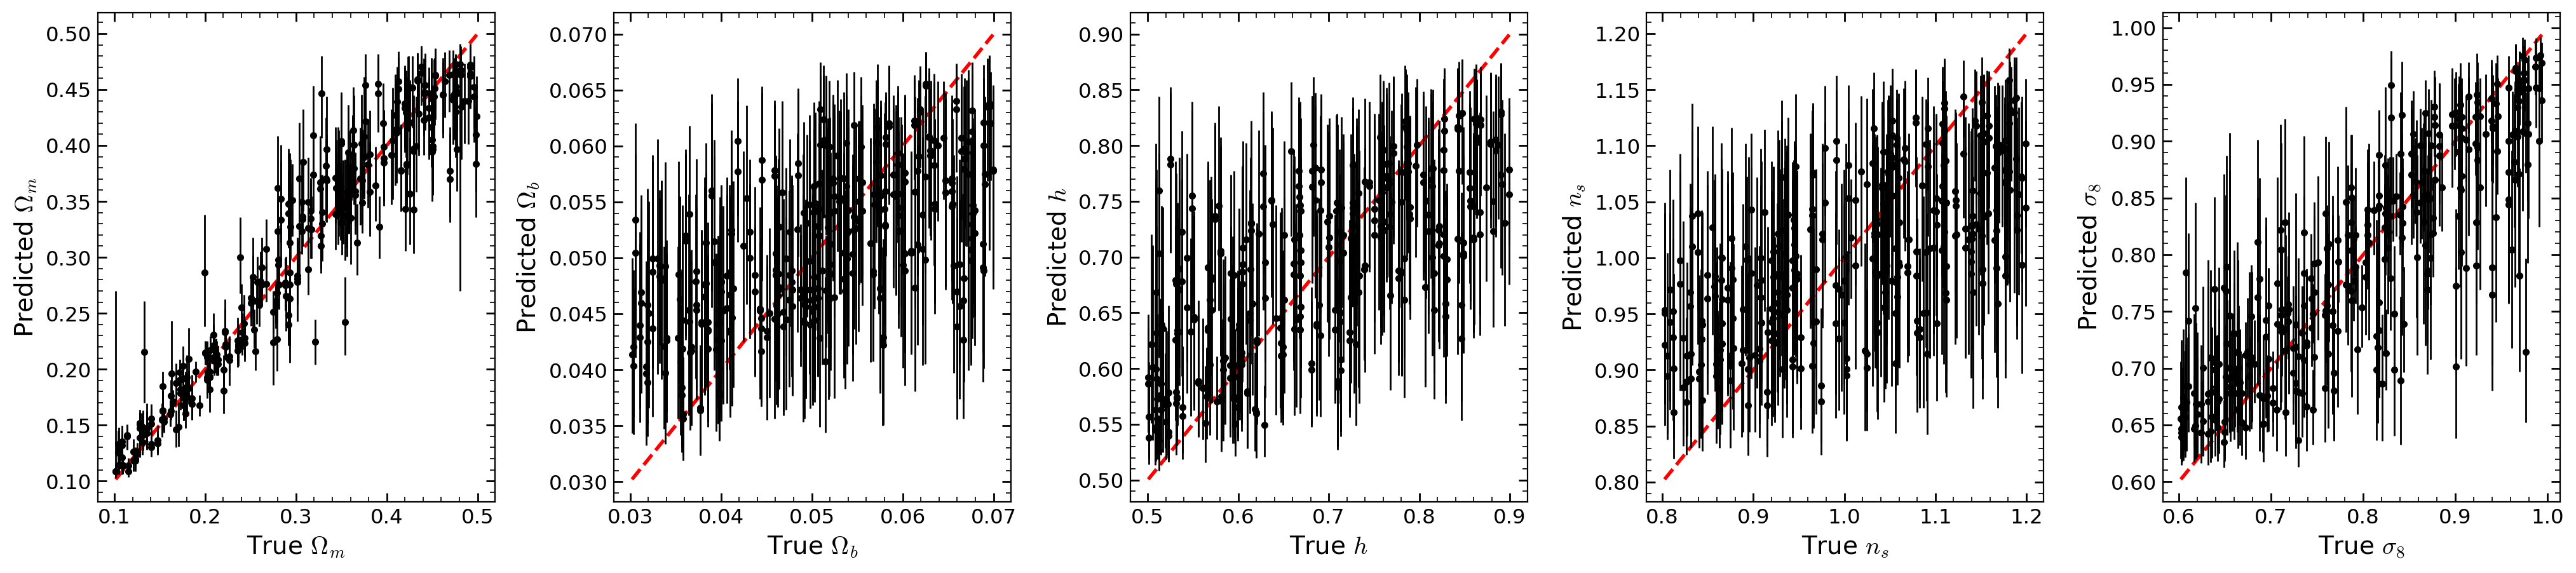

In [18]:

ss = 3

N = len(names)
H, W = N//5, 5
f, axs = plt.subplots(H, W, figsize=(5*W, 5*H), gridspec_kw=dict(wspace=0.3))
axs = axs.flatten()

for i, ax in enumerate(axs):
    if i >= N:
        ax.axis('off')
        continue
    ax.plot(yrange[i], yrange[i], 'r--')
    ax.plot(ytest[::ss, i], percs[1, ::ss, i], 'k.')
    ax.errorbar(ytest[::ss, i], percs[1, ::ss, i], yerr=[percs[1, ::ss, i]-percs[0, ::ss, i],
                percs[2, ::ss, i]-percs[1, ::ss, i]], fmt='none', ecolor='k', elinewidth=1)
    ax.set(xlabel=f'True {names[i]}', ylabel=f'Predicted {names[i]}')

In [19]:
# these functions load pickled torch modules
# if the model was trained on GPU, this will ensure safe loading to CPU
# TODO: update ltu-ili so this is already handled...

import torch
import io


class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)


def load_posterior(modeldir):
    with open(join(modeldir, 'posterior.pkl'), 'rb') as f:
        ensemble = CPU_Unpickler(f).load()
    ensemble = ensemble.to(device)
    for p in ensemble.posteriors:
        p.to(device)
    return ensemble


posterior = load_posterior(modelpath)
for p in posterior.posteriors:
    print(type(p.nde.flow))

<class 'zuko.flows.autoregressive.MAF'>
<class 'zuko.flows.autoregressive.MAF'>
<class 'zuko.flows.autoregressive.MAF'>
<class 'zuko.flows.autoregressive.MAF'>
<class 'zuko.flows.autoregressive.MAF'>
<class 'zuko.flows.autoregressive.MAF'>
<class 'zuko.flows.autoregressive.MAF'>
<class 'zuko.flows.autoregressive.MAF'>
<class 'zuko.flows.autoregressive.MAF'>
<class 'zuko.flows.autoregressive.MAF'>


100%|██████████| 20/20 [00:00<00:00, 291.63it/s]


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Log Probability')]

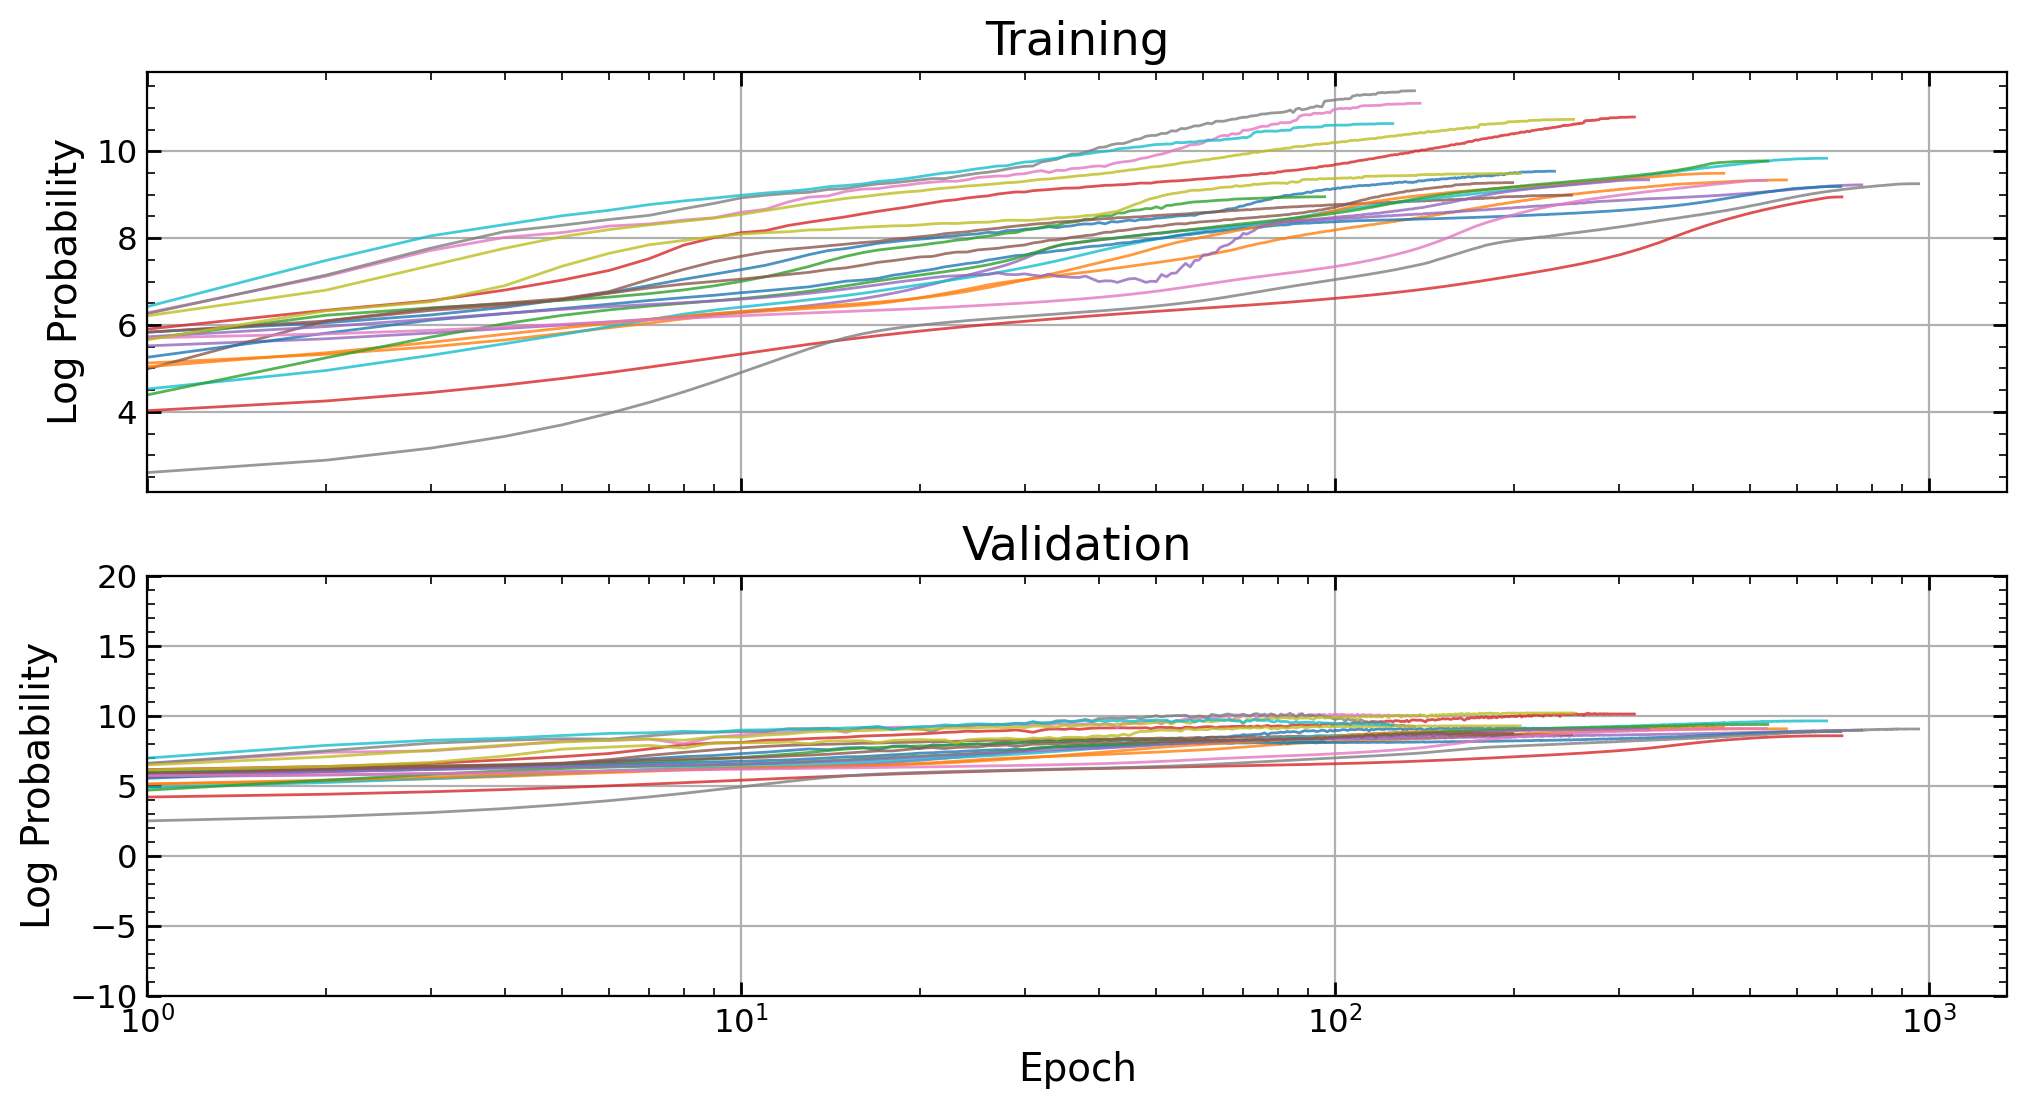

In [20]:
ss = 5

netpath = join(modelpath, 'nets')
netlist = os.listdir(netpath)

f, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

for n in tqdm(netlist[::ss]):
    filepath = join(netpath, n, 'summary.json')
    if not os.path.exists(filepath):
        continue
    with open(filepath, 'r') as f:
        history = json.load(f)

    x_ = range(1, len(history[0]['training_log_probs'])+1)

    ax = axs[0]
    ax.plot(x_, history[0]['training_log_probs'], alpha=0.8, lw=1)

    ax = axs[1]
    ax.plot(x_, history[0]['validation_log_probs'], alpha=0.8, lw=1)

ax.semilogx()
ax.set_xlim(1)
ax.set_ylim(-10, 20)

axs[0].set_title('Training')
axs[1].set_title('Validation')
axs[0].grid()
axs[1].grid()

axs[0].set(ylabel='Log Probability')
axs[1].set(xlabel='Epoch', ylabel='Log Probability')

INFO:root:Sampling models with [230, 207, 202, 201, 200, 199, 198, 198, 189, 182] samples each.
Drawing 230 posterior samples: 417it [00:01, 226.24it/s]                         
Drawing 207 posterior samples: 375it [00:03, 123.64it/s]                         
Drawing 202 posterior samples: 349it [00:02, 134.59it/s]                         
Drawing 201 posterior samples: 389it [00:02, 130.91it/s]                         
Drawing 200 posterior samples: 356it [00:00, 485.61it/s]                         
Drawing 199 posterior samples: 374it [00:02, 144.26it/s]                         
Drawing 198 posterior samples: 337it [00:01, 302.67it/s]                         
Drawing 198 posterior samples: 374it [00:01, 252.12it/s]                         
Drawing 189 posterior samples: 334it [00:03, 100.03it/s]                        
Drawing 182 posterior samples: 339it [00:01, 305.40it/s]                         


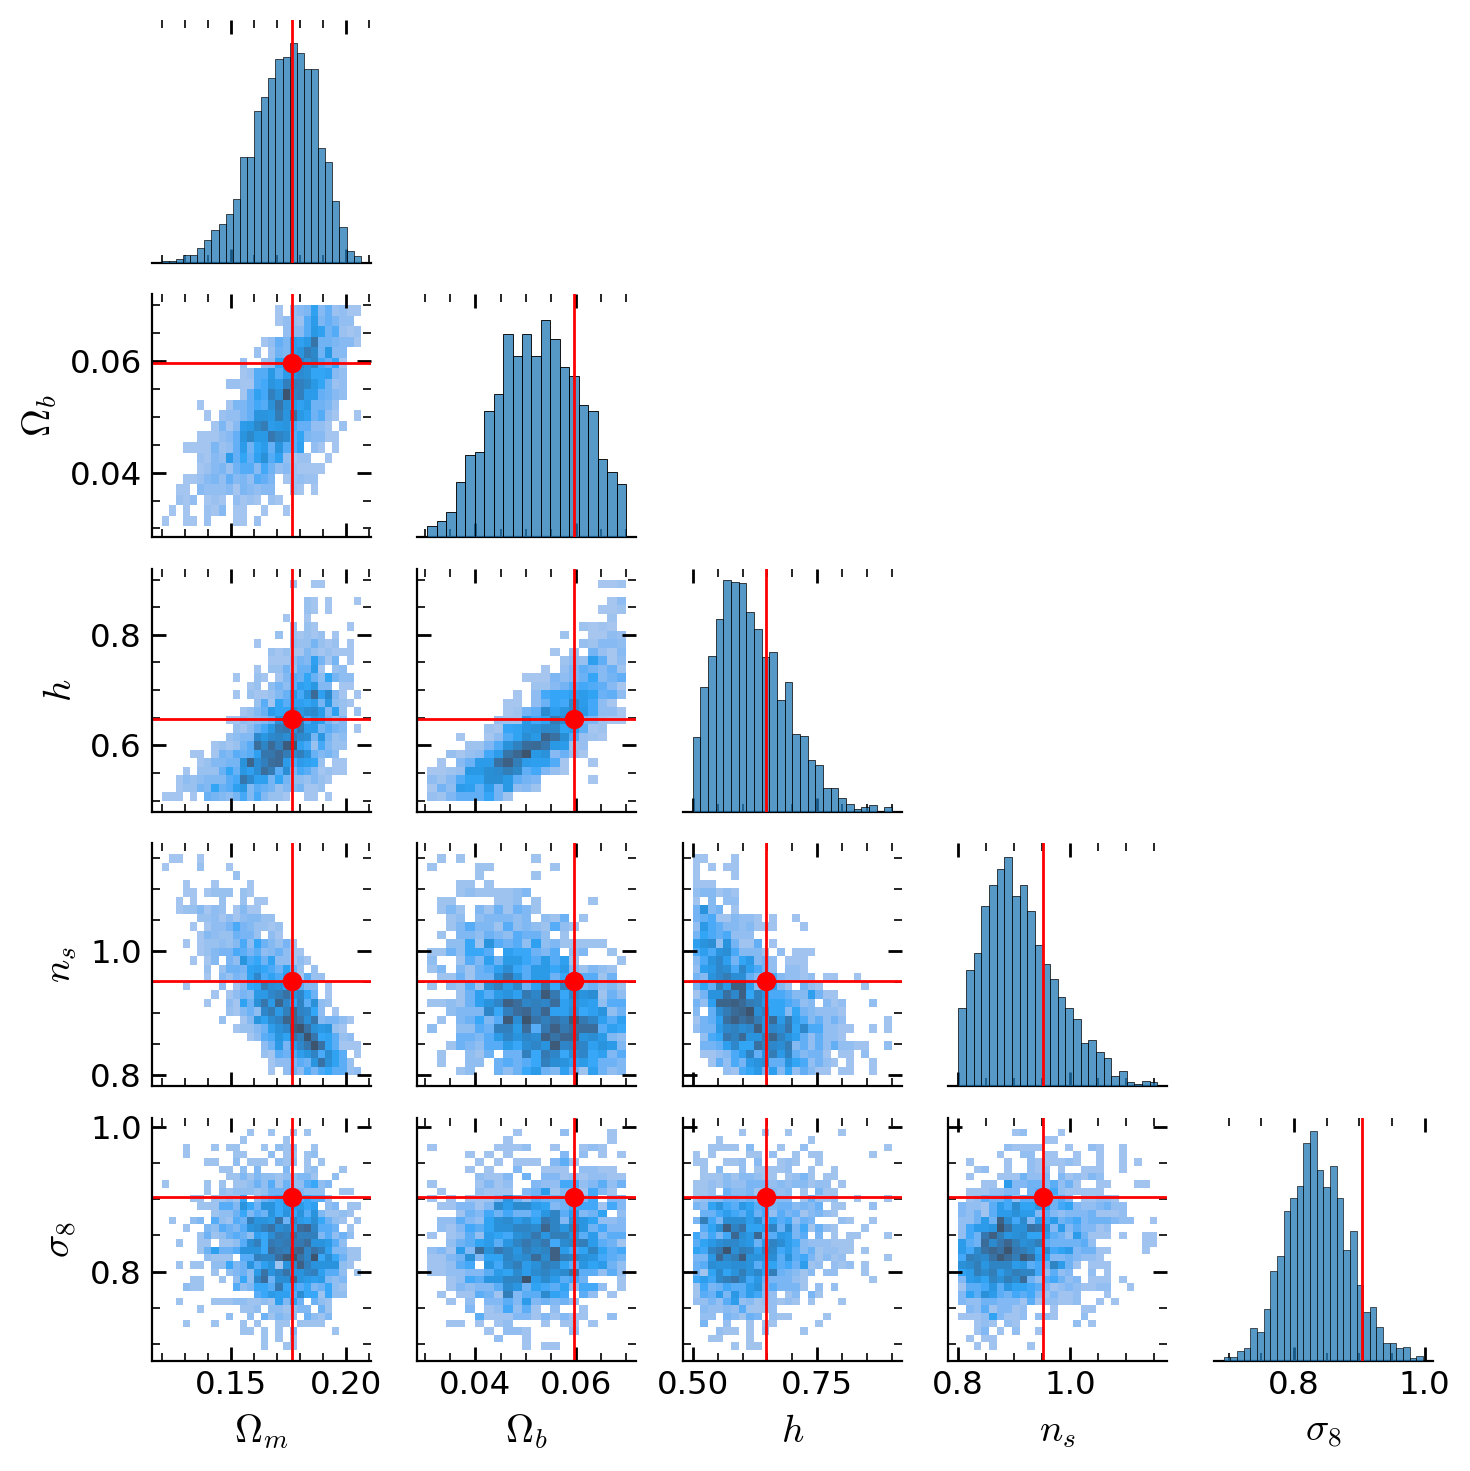

In [21]:
# Predict on a random test point
ind = 15
x0 = torch.Tensor(xtest[ind]).to(device)
y0 = ytest[ind]
samp0 = posterior.sample(x=x0, shape=(2000,))
samp0 = pd.DataFrame(samp0, columns=names)


def plot_true_vals(grid, true_vals, **kwargs):
    for i, val in enumerate(true_vals):
        grid.diag_axes[i].axvline(val, **kwargs)
        for j, ax in enumerate(grid.axes[i, :i]):
            if ax:
                ax.axvline(true_vals[j], **kwargs)
                ax.axhline(val, **kwargs)
                ax.plot(true_vals[j], val, 'o', **kwargs)


g = sns.pairplot(
    samp0,
    vars=names,
    kind='hist',
    corner=True,
    height=1.5
    # plot_kws={'alpha': 0.5, 'levels': [0.05, 0.36, 1], 'fill': True},  # for kde plot
)

plot_true_vals(g, y0, color='r', lw=1)

## Load an observed summary

In [37]:
# Load observed data
nbody = 'abacus1gpch'
sim = 'correct'
save_dir = join(wdir, nbody, sim, 'models')
modelpath = join(save_dir, tracer, summary, f'kmin-{kmin}_kmax-{kmax}')

xobs = np.load(join(modelpath, 'x_test.npy'))
yobs = np.load(join(modelpath, 'theta_test.npy'))
xid = np.load(join(modelpath, 'ids_test.npy'))

xobs = xobs[::2]
yobs = yobs[::2]
xid = xid[::2]
# xobs = xobs[:15]
# yobs = yobs[:15]
# xid = xid[:15]

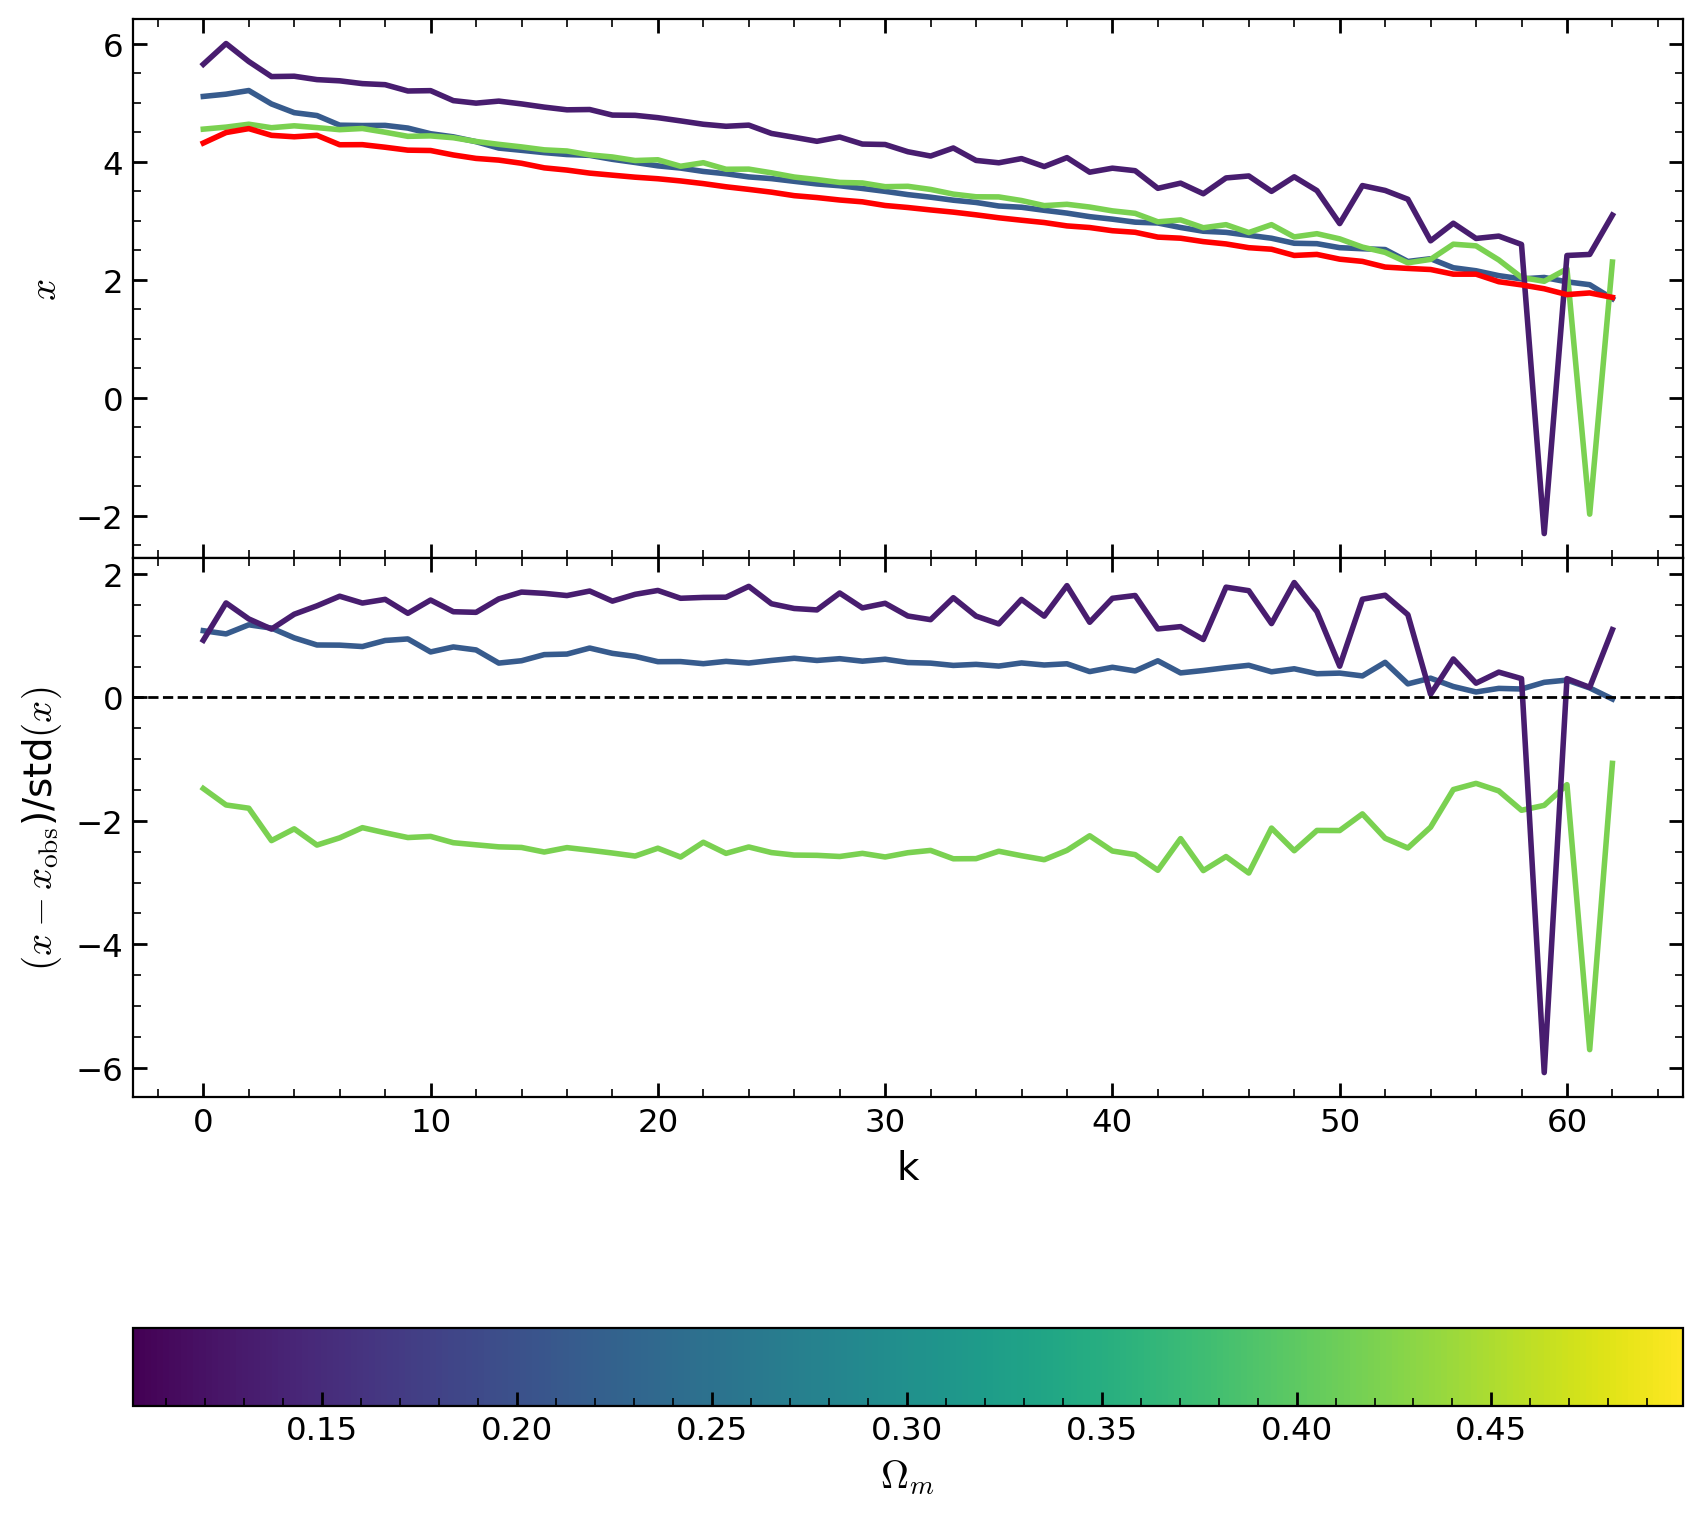

In [38]:
import matplotlib.colors as mcolors

ss = 5
ind = 0

f, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True,
                      gridspec_kw=dict(hspace=0., height_ratios=[1, 1]))

par = ytest[:, 0]
cmap = plt.get_cmap('viridis')
norm = mcolors.Normalize(vmin=par.min(), vmax=par.max())

ax = axs[0]
for i in range(0, len(xobs), ss):
    ax.plot(xtest[i], color=cmap(norm(par[i])))
ax.plot(xobs[ind], 'r-', lw=2)
ax.set(ylabel=r'$x$')

ax = axs[1]
for i in range(0, len(xobs), ss):
    ax.plot((xtest[i]-xobs[i])/np.std(xtest, axis=0), color=cmap(norm(par[i])))
ax.axhline(0, c='k', ls='--', lw=1)
ax.set(xlabel='k', ylabel=r'$(x - x_{\rm obs}$)/std$(x)$')

cbar = f.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                  ax=axs, orientation='horizontal')
cbar.set_label(r'$\Omega_m$')

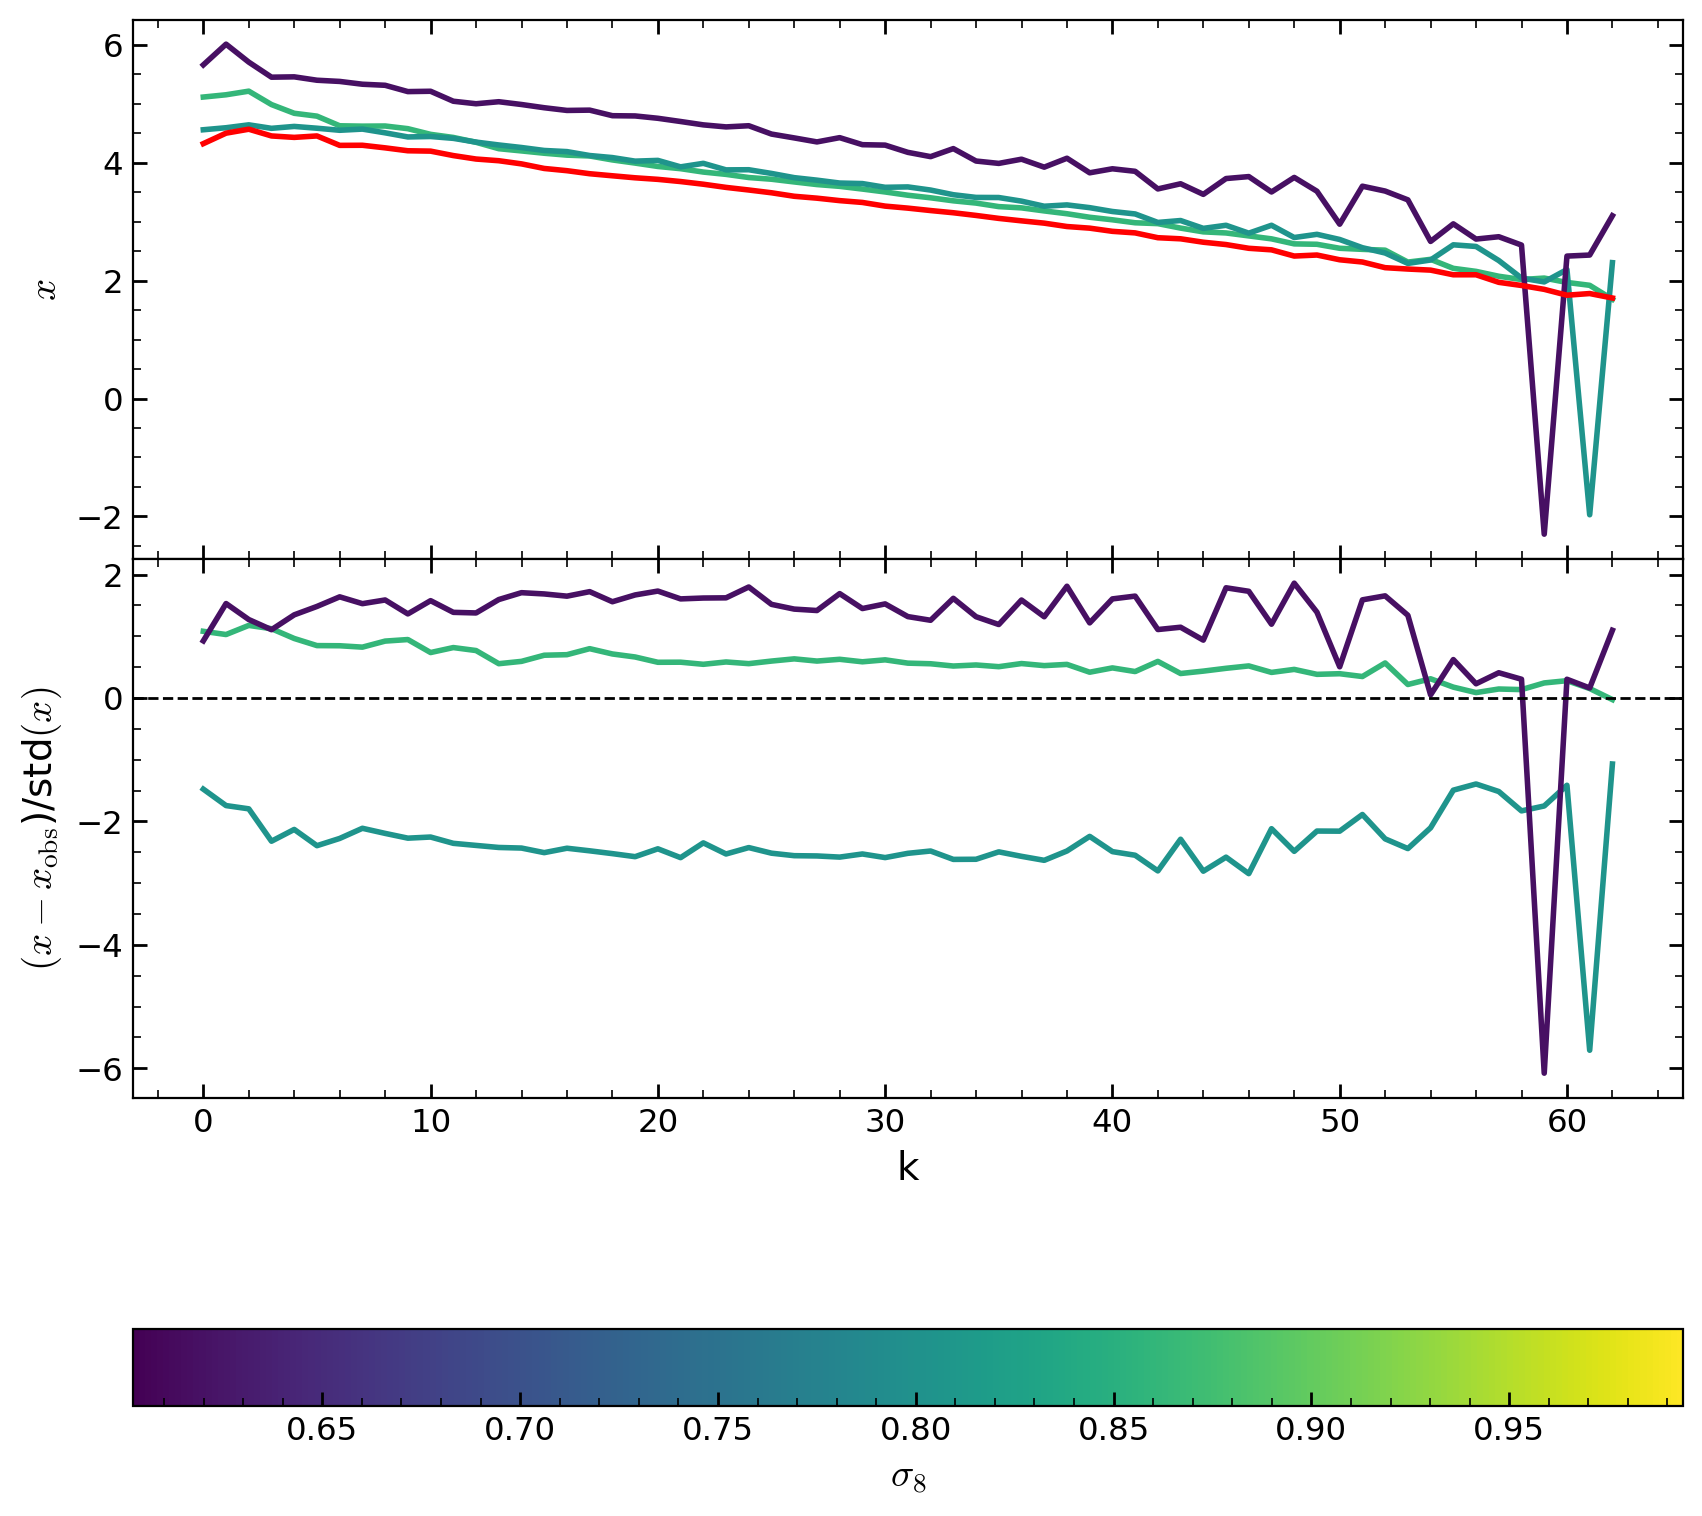

In [39]:
import matplotlib.colors as mcolors

ss = 5
ind = 0

f, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True,
                      gridspec_kw=dict(hspace=0., height_ratios=[1, 1]))

par = ytest[:, 4]
cmap = plt.get_cmap('viridis')
norm = mcolors.Normalize(vmin=par.min(), vmax=par.max())

ax = axs[0]
for i in range(0, len(xobs), ss):
    ax.plot(xtest[i], color=cmap(norm(par[i])))
ax.plot(xobs[ind], 'r-', lw=2)
ax.set(ylabel=r'$x$')

ax = axs[1]
for i in range(0, len(xobs), ss):
    ax.plot((xtest[i]-xobs[i])/np.std(xtest, axis=0), color=cmap(norm(par[i])))
ax.axhline(0, c='k', ls='--', lw=1)
ax.set(xlabel='k', ylabel=r'$(x - x_{\rm obs}$)/std$(x)$')

cbar = f.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                  ax=axs, orientation='horizontal')
cbar.set_label(r'$\sigma_8$')

INFO:root:Sampling models with [229, 207, 202, 201, 200, 199, 198, 198, 189, 182] samples each.
Drawing 229 posterior samples: 427it [00:00, 24398.11it/s]            
Drawing 207 posterior samples: 384it [00:00, 15669.12it/s]            
Drawing 202 posterior samples: 381it [00:00, 20443.53it/s]            
Drawing 201 posterior samples: 357it [00:00, 14755.43it/s]            
Drawing 200 posterior samples: 362it [00:00, 53385.54it/s]            
Drawing 199 posterior samples: 371it [00:00, 19312.76it/s]            
Drawing 198 posterior samples: 362it [00:00, 35565.76it/s]            
Drawing 198 posterior samples: 342it [00:00, 30042.14it/s]            
Drawing 189 posterior samples: 347it [00:00, 13575.32it/s]            
Drawing 182 posterior samples: 353it [00:00, 35091.71it/s]            


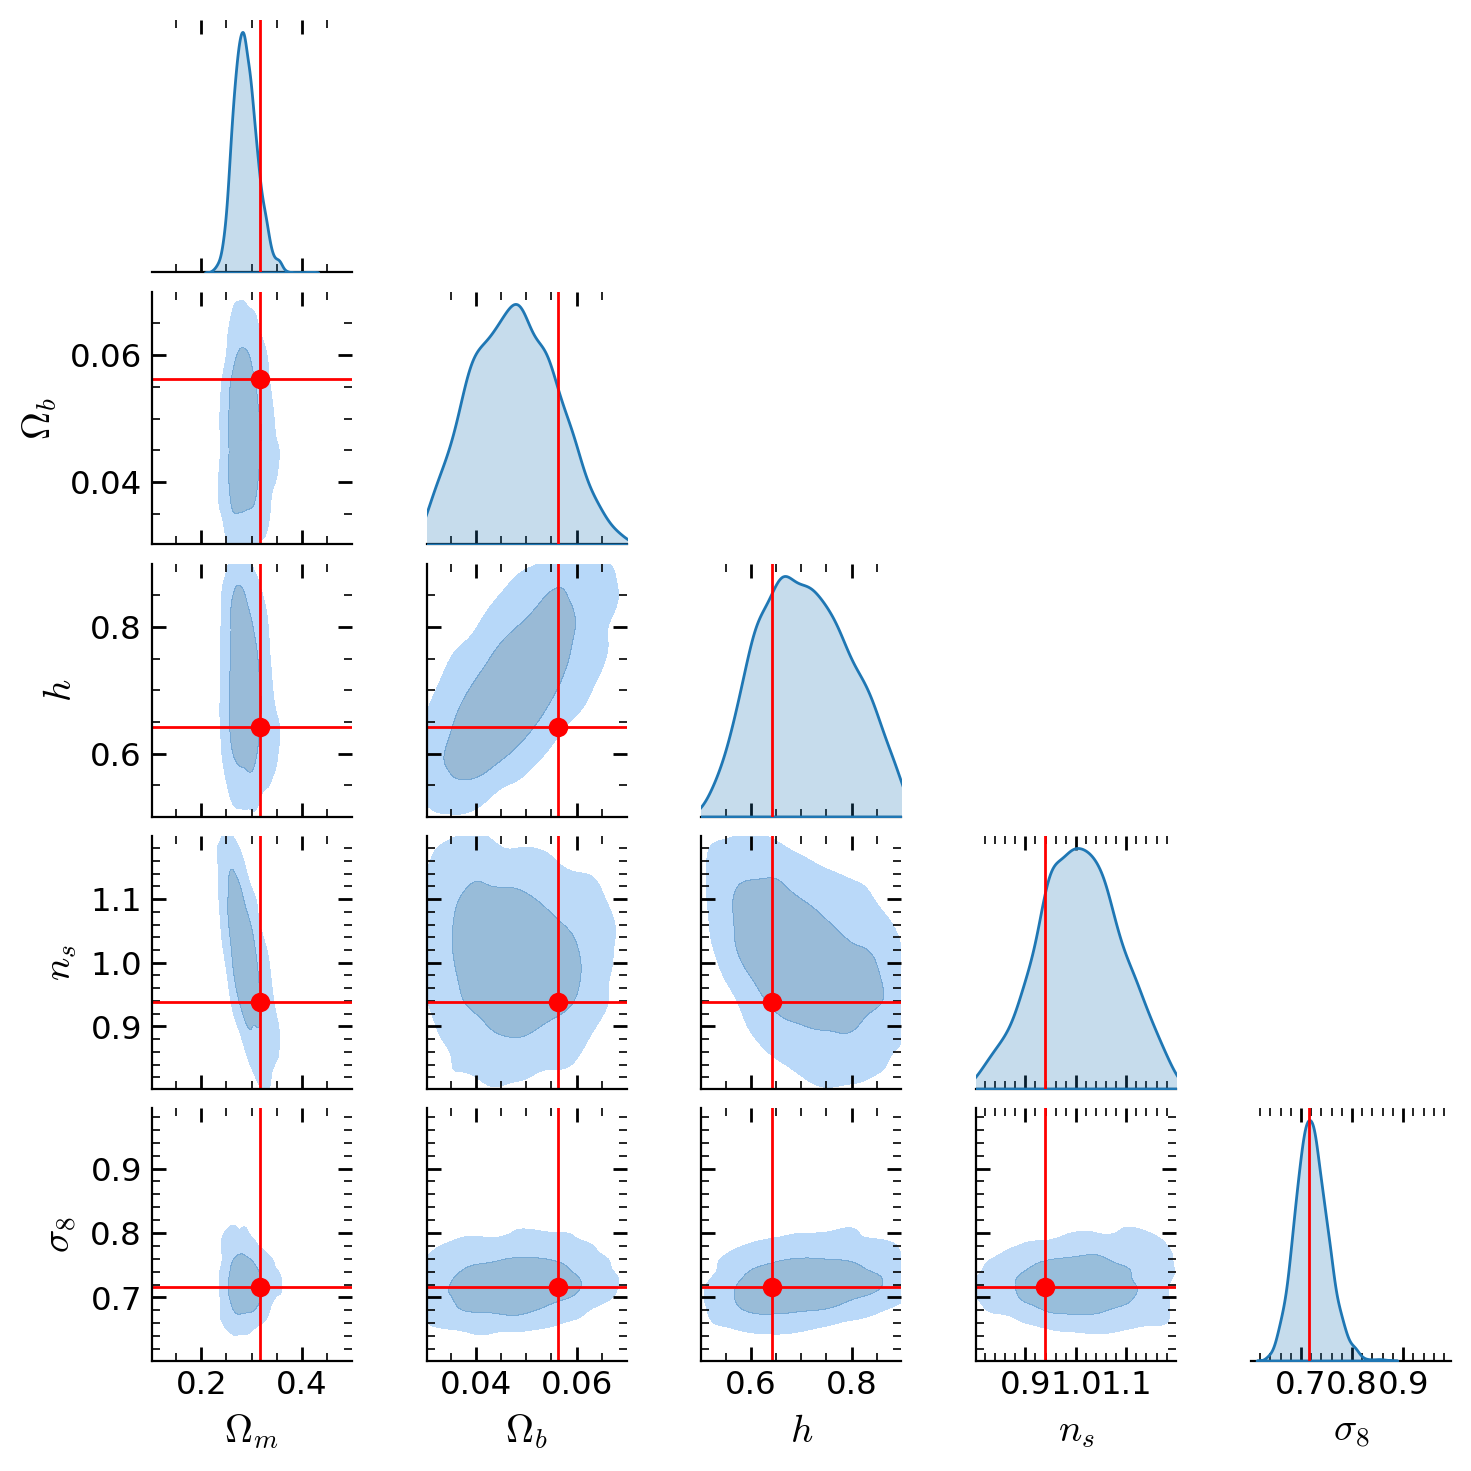

In [40]:
# Predict on a random test point
ind = 11
samp0 = posterior.sample(x=xobs[ind], shape=(1999,)).to('cpu')
samp0 = pd.DataFrame(samp0, columns=names)


def plot_true_vals(grid, true_vals, **kwargs):
    for i, val in enumerate(true_vals):
        grid.diag_axes[i].axvline(val, **kwargs)
        for j, ax in enumerate(grid.axes[i, :i]):
            if ax:
                ax.axvline(true_vals[j], **kwargs)
                ax.axhline(val, **kwargs)
                ax.plot(true_vals[j], val, 'o', **kwargs)


def set_boundaries(grid, prior_range):
    for i, (x, y) in enumerate(prior_range):
        grid.diag_axes[i].set_xlim(x, y)
        for j, ax in enumerate(grid.axes[i, :i]):
            if ax:
                ax.set_ylim(x, y)
                ax.set_xlim(*prior_range[j])


g = sns.pairplot(
    samp0,
    vars=names,
    kind='kde',
    plot_kws={'alpha': 0.5, 'levels': [
        0.05, 0.36, 1], 'fill': True, 'common_norm': False},
    corner=True,
    height=1.5
    # plot_kws={'alpha': 0.5, 'levels': [0.05, 0.36, 1], 'fill': True},  # for kde plot
)

plot_true_vals(g, yobs[ind], color='r', lw=1)
set_boundaries(g, yrange)

## Predict on a suite of summaries

In [41]:
samps = []
for xin in tqdm(xobs):
    samp = posterior.sample(x=xin, shape=(
        1000,), show_progress_bars=False).to('cpu')
    samps.append(samp)

100%|██████████| 13/13 [02:32<00:00, 11.76s/it]


In [42]:
samps = np.array(samps)
trues = np.array(yobs)
# trues.shape, samps.shape

Text(0.5, 0.98, 'zPk0 Without Abacus prior correction')

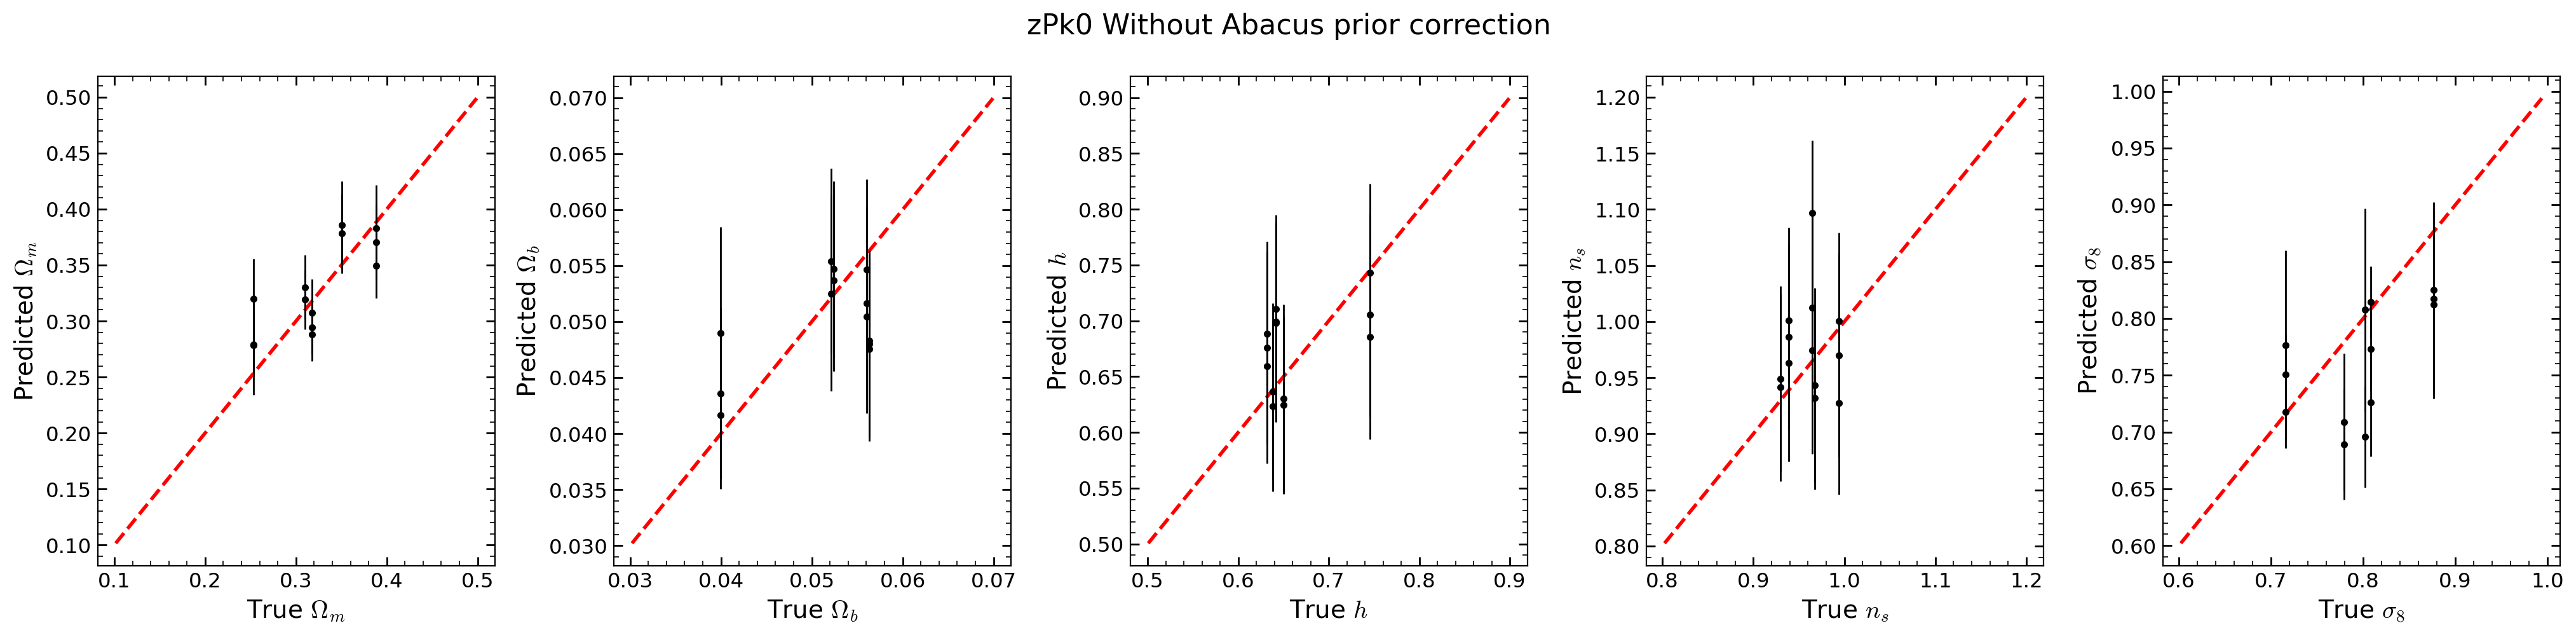

In [43]:
Nparams = trues.shape[-1]

H, W = Nparams//5, 5
f, axs = plt.subplots(H, W, figsize=(W*5, H*5), gridspec_kw=dict(wspace=0.3))
axs = axs.flatten()
for i in range(Nparams):
    means = np.average(samps[:, :, i], axis=1)
    stds = np.sqrt(np.average((samps[:, :, i] - means[:, None])**2, axis=1))
    axs[i].plot(yrange[i], yrange[i], 'r--')
    axs[i].plot(trues[:, i], means, 'k.')
    axs[i].errorbar(trues[:, i], means, yerr=stds,
                    fmt='none', ecolor='k', elinewidth=1)
    axs[i].set(xlabel=f'True {names[i]}', ylabel=f'Predicted {names[i]}')
f.suptitle('+'.join(summaries)+' Without Abacus prior correction', fontsize=16)

In [44]:
weights = samps[:, :, 2]**4
weights /= weights.sum(axis=1)[:, None]

Text(0.5, 0.98, 'zPk0 With Abacus prior correction')

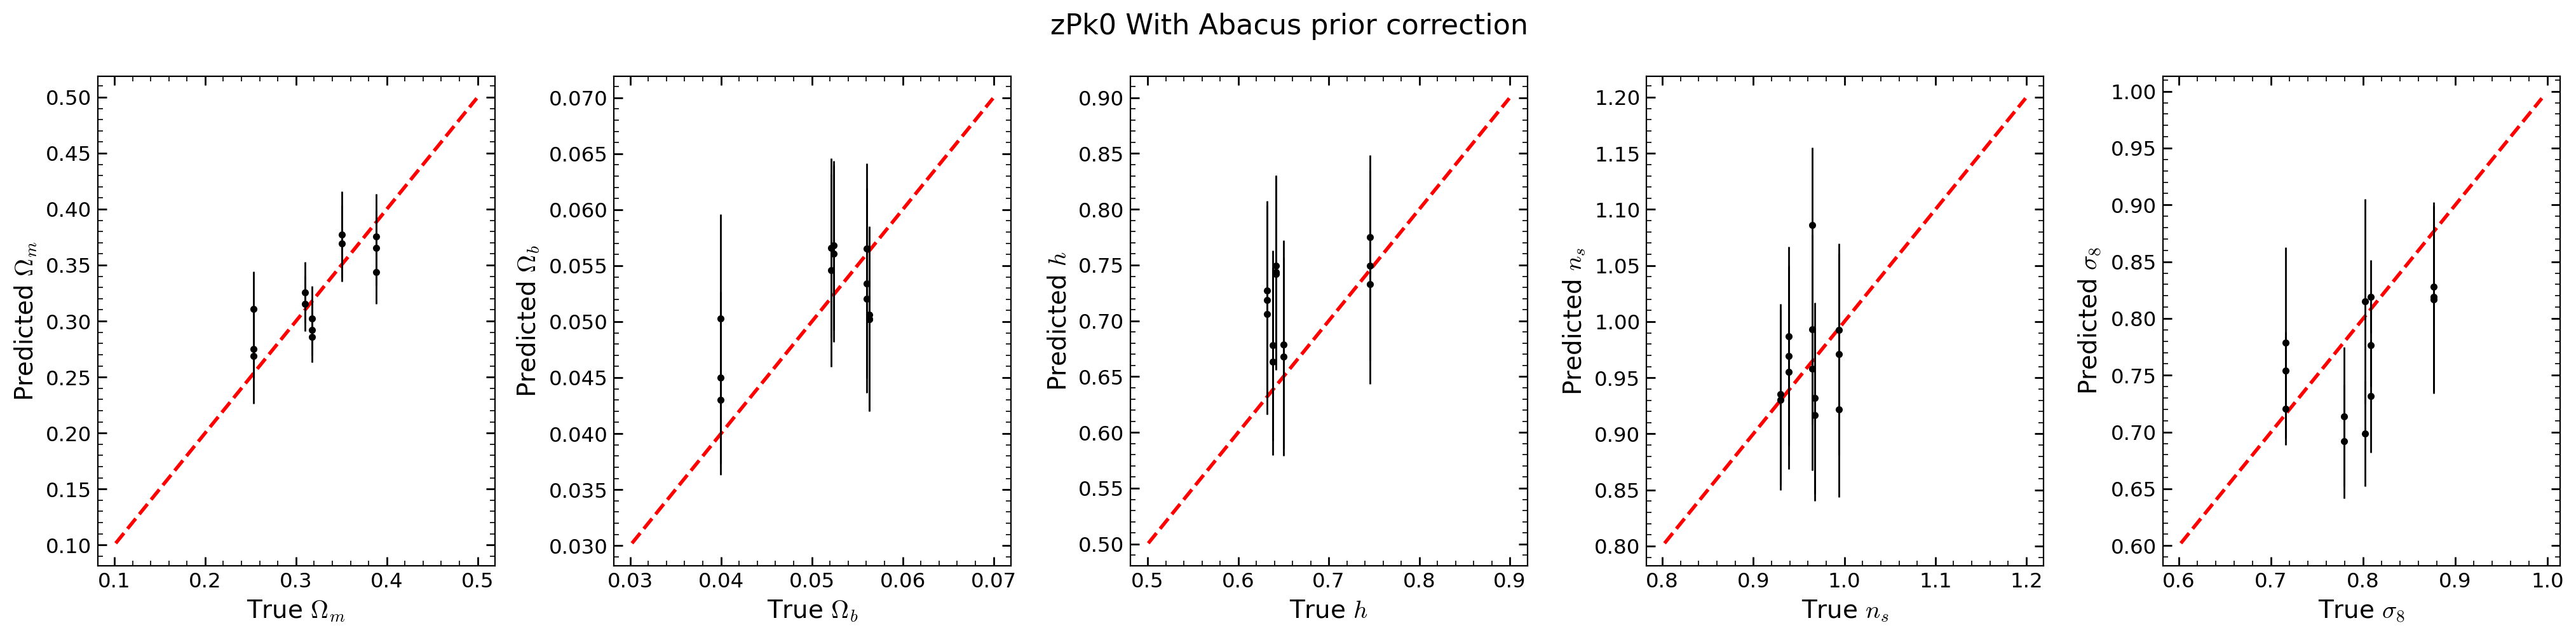

In [45]:
Nparams = trues.shape[-1]

H, W = Nparams//5, 5
f, axs = plt.subplots(H, W, figsize=(W*5, H*5), gridspec_kw=dict(wspace=0.3))
axs = axs.flatten()
for i in range(Nparams):
    means = np.average(samps[:, :, i], axis=1, weights=weights)
    stds = np.sqrt(np.average(
        (samps[:, :, i] - means[:, None])**2, axis=1, weights=weights))
    axs[i].plot(yrange[i], yrange[i], 'r--')
    axs[i].plot(trues[:, i], means, 'k.')
    axs[i].errorbar(trues[:, i], means, yerr=stds,
                    fmt='none', ecolor='k', elinewidth=1)
    axs[i].set(xlabel=f'True {names[i]}', ylabel=f'Predicted {names[i]}')
f.suptitle('+'.join(summaries)+' With Abacus prior correction', fontsize=16)

## Find out what the hell is going on

In [ ]:
# find similar quijote and abacus cosmologies
import numpy as np
from scipy.spatial.distance import cdist
filename = '/home/x-mho1/git/ltu-cmass/params/latin_hypercube_params.txt'
qparams = pd.read_csv(filename, delim_whitespace=True, header=None)

filename = '/home/x-mho1/git/ltu-cmass/params/abacus_cosmologies.txt'
aparams = pd.read_csv(filename, delim_whitespace=True, header=None)
aparams = aparams.iloc[130:182]


# Compute the pairwise distances between aparams and qparams
distances = cdist(aparams.values, qparams.values, metric='euclidean')

# Find the indices of the minimum distance
min_idx = np.unravel_index(np.argmin(distances), distances.shape)
aparams_idx, qparams_idx = min_idx

# Retrieve the closest rows
closest_aparams = aparams.iloc[aparams_idx]
closest_qparams = qparams.iloc[qparams_idx]

print(f"Closest aparams row (index {aparams_idx}):\n{closest_aparams}")
print(f"Closest qparams row (index {qparams_idx}):\n{closest_qparams}")
print(f"Minimum distance: {distances[aparams_idx, qparams_idx]}")

Closest aparams row (index 6):
0    0.319490
1    0.047331
2    0.661800
3    0.930300
4    0.882475
Name: 136, dtype: float64
Closest qparams row (index 678):
0    0.32010
1    0.03365
2    0.66270
3    0.93870
4    0.88710
Name: 678, dtype: float64
Minimum distance: 0.01674223658893874


In [5]:
lhid = 678
filename = f'/anvil/scratch/x-mho1/cmass-ili/quijote/nbody/L1000-N128/{lhid}/halos.h5'
# filename = f'/anvil/scratch/x-mho1/cmass-ili/abacus/correct/L2000-N256/{lhid}/halos.h5'
# filename = f'/anvil/scratch/x-mho1/abacus/h5/{lhid}/halos.h5'
a = '0.666667'
with h5py.File(filename, 'r') as f:
    amass, apos, avel = f[a]['mass'][()], f[a]['pos'][()], f[a]['vel'][()]
    print(f'Loaded {lhid} with {len(amass)} halos')

lhid = 136
filename = f'/anvil/scratch/x-mho1/cmass-ili/abacus1gpch/correct/L1000-N128/{lhid}/halos.h5'
a = '0.666667'
with h5py.File(filename, 'r') as f:
    cmass, cpos, cvel = f[a]['mass'][()], f[a]['pos'][()], f[a]['vel'][()]
    print(f'Loaded {lhid} with {len(cmass)} halos')

Loaded 678 with 704794 halos
Loaded 136 with 1281486 halos


[Text(0.5, 0, '$\\log_{10} M_{\\rm halo}^{\\rm Abacus}$'),
 Text(0, 0.5, '$\\log_{10} M_{\\rm halo}^{\\rm FastPM}$')]

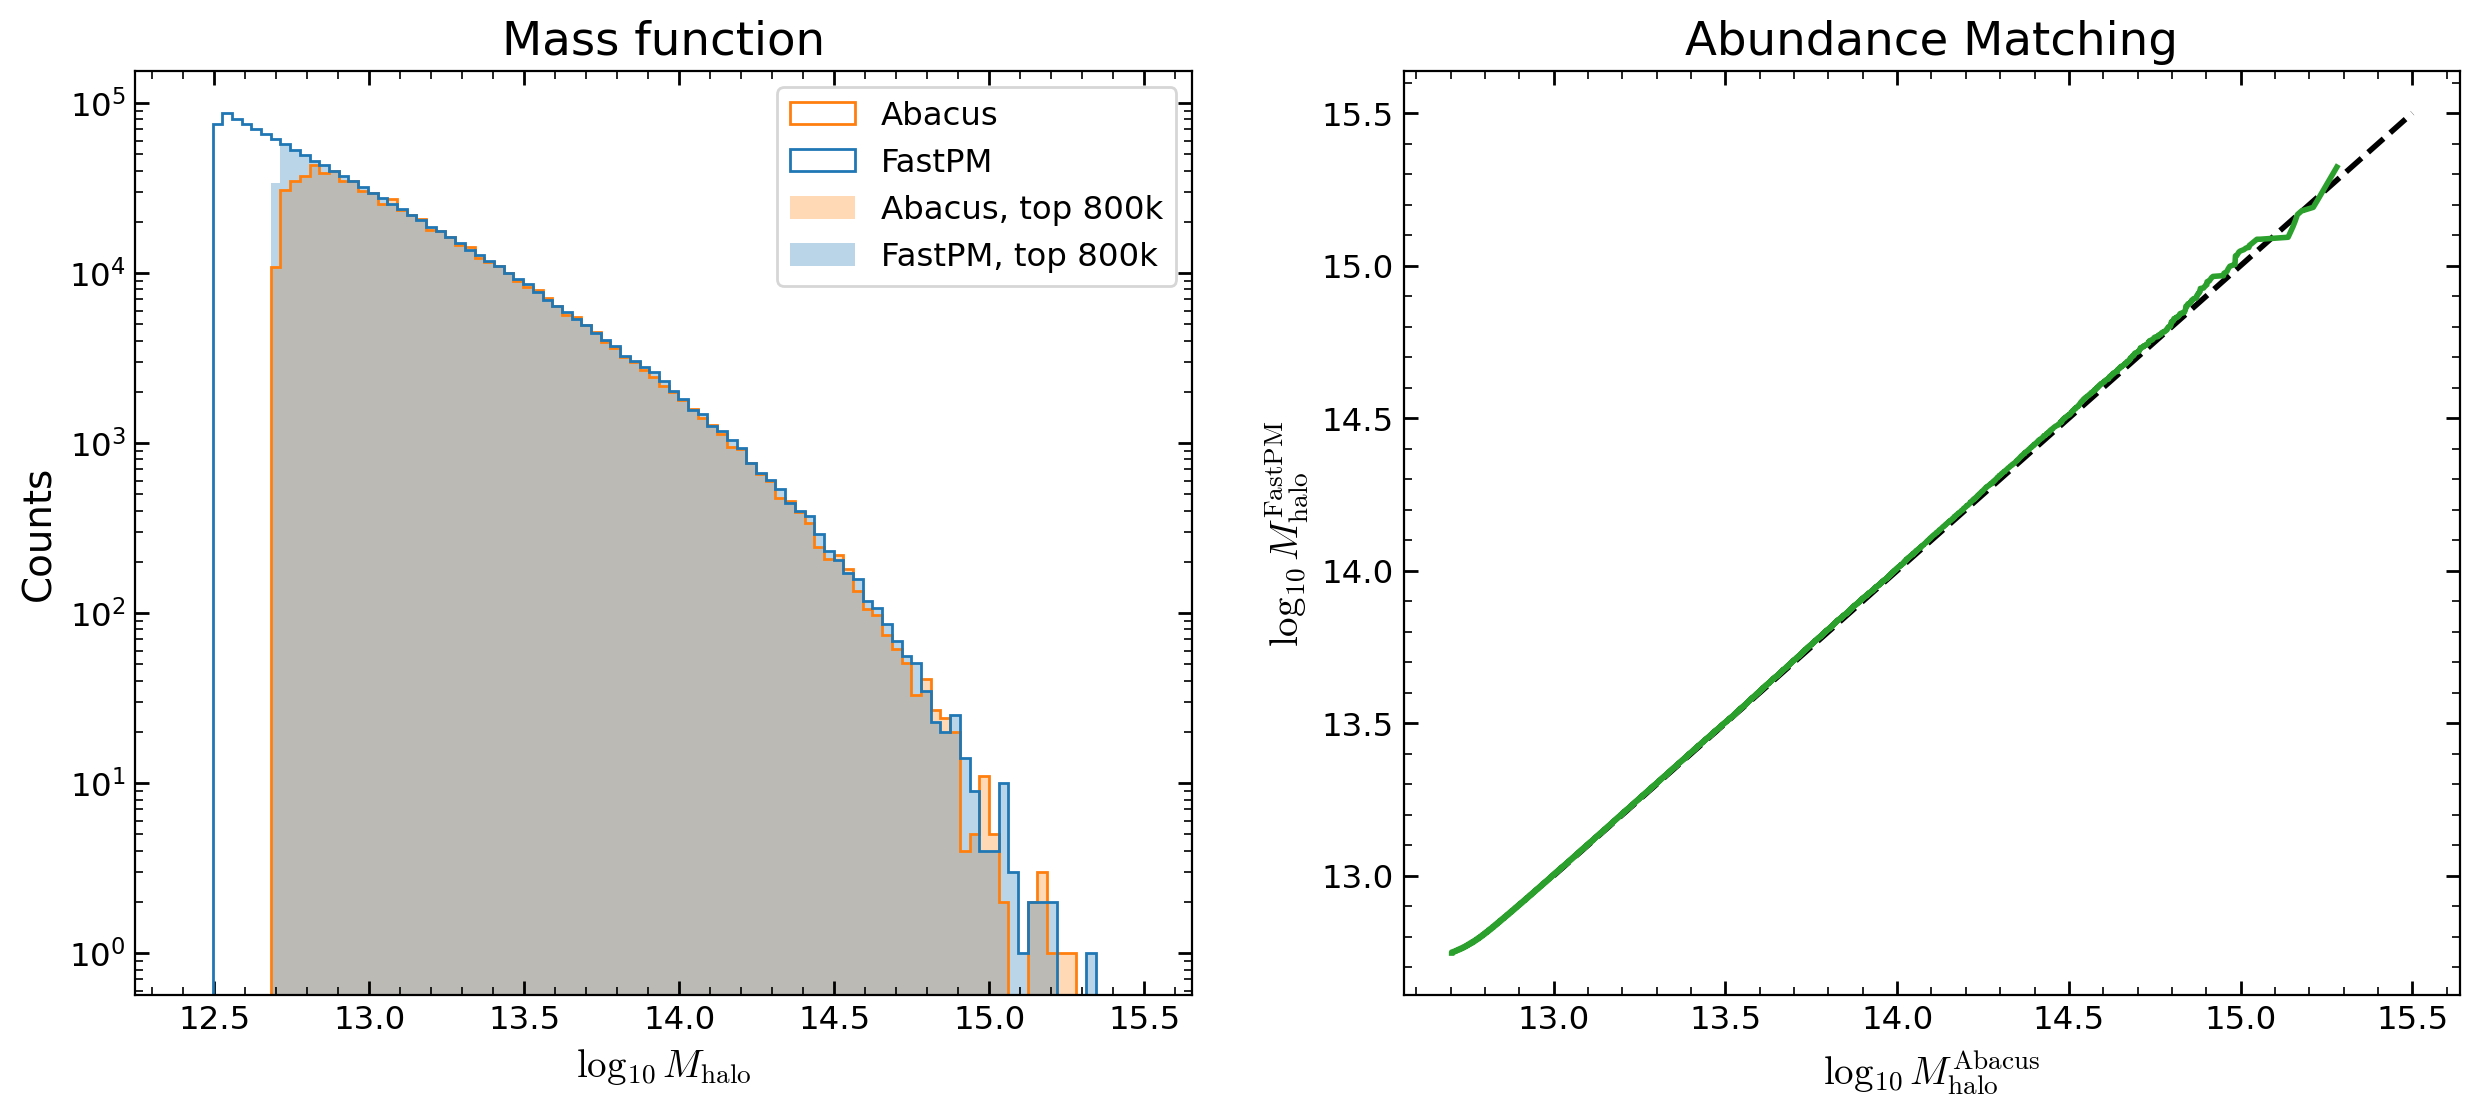

In [6]:
f, axs = plt.subplots(1, 2, figsize=(15, 6))

ax = axs[0]
ax.semilogy()
mbins = np.linspace(12.4, 15.5, 100)
ax.hist(amass, bins=mbins, histtype='step', color='C1', label='Abacus', lw=2)
ax.hist(cmass, bins=mbins, histtype='step', color='C0', label='FastPM', lw=2)
ax.hist(sorted(amass)[-int(8e5):], bins=mbins, histtype='bar',
        color='C1', label='Abacus, top 800k', alpha=0.3)
ax.hist(sorted(cmass)[-int(8e5):], bins=mbins, histtype='bar',
        color='C0', label='FastPM, top 800k', alpha=0.3)
ax.legend()
ax.set(xlabel=r'$\log_{10} M_{\rm halo}$', ylabel='Counts')
ax.set_title('Mass function')

ax = axs[1]
x = sorted(amass)
y = sorted(cmass)
N = min(len(x), len(y))
ax.plot([13, 15.5], [13, 15.5], 'k--')
ax.plot(x[-N:], y[-N:], '-', c='C2', markersize=0.1)
ax.set_title('Abundance Matching')
ax.set(xlabel=r'$\log_{10} M_{\rm halo}^{\rm Abacus}$',
       ylabel=r'$\log_{10} M_{\rm halo}^{\rm FastPM}$')

Text(0.5, 1.0, '400k-600k halos')

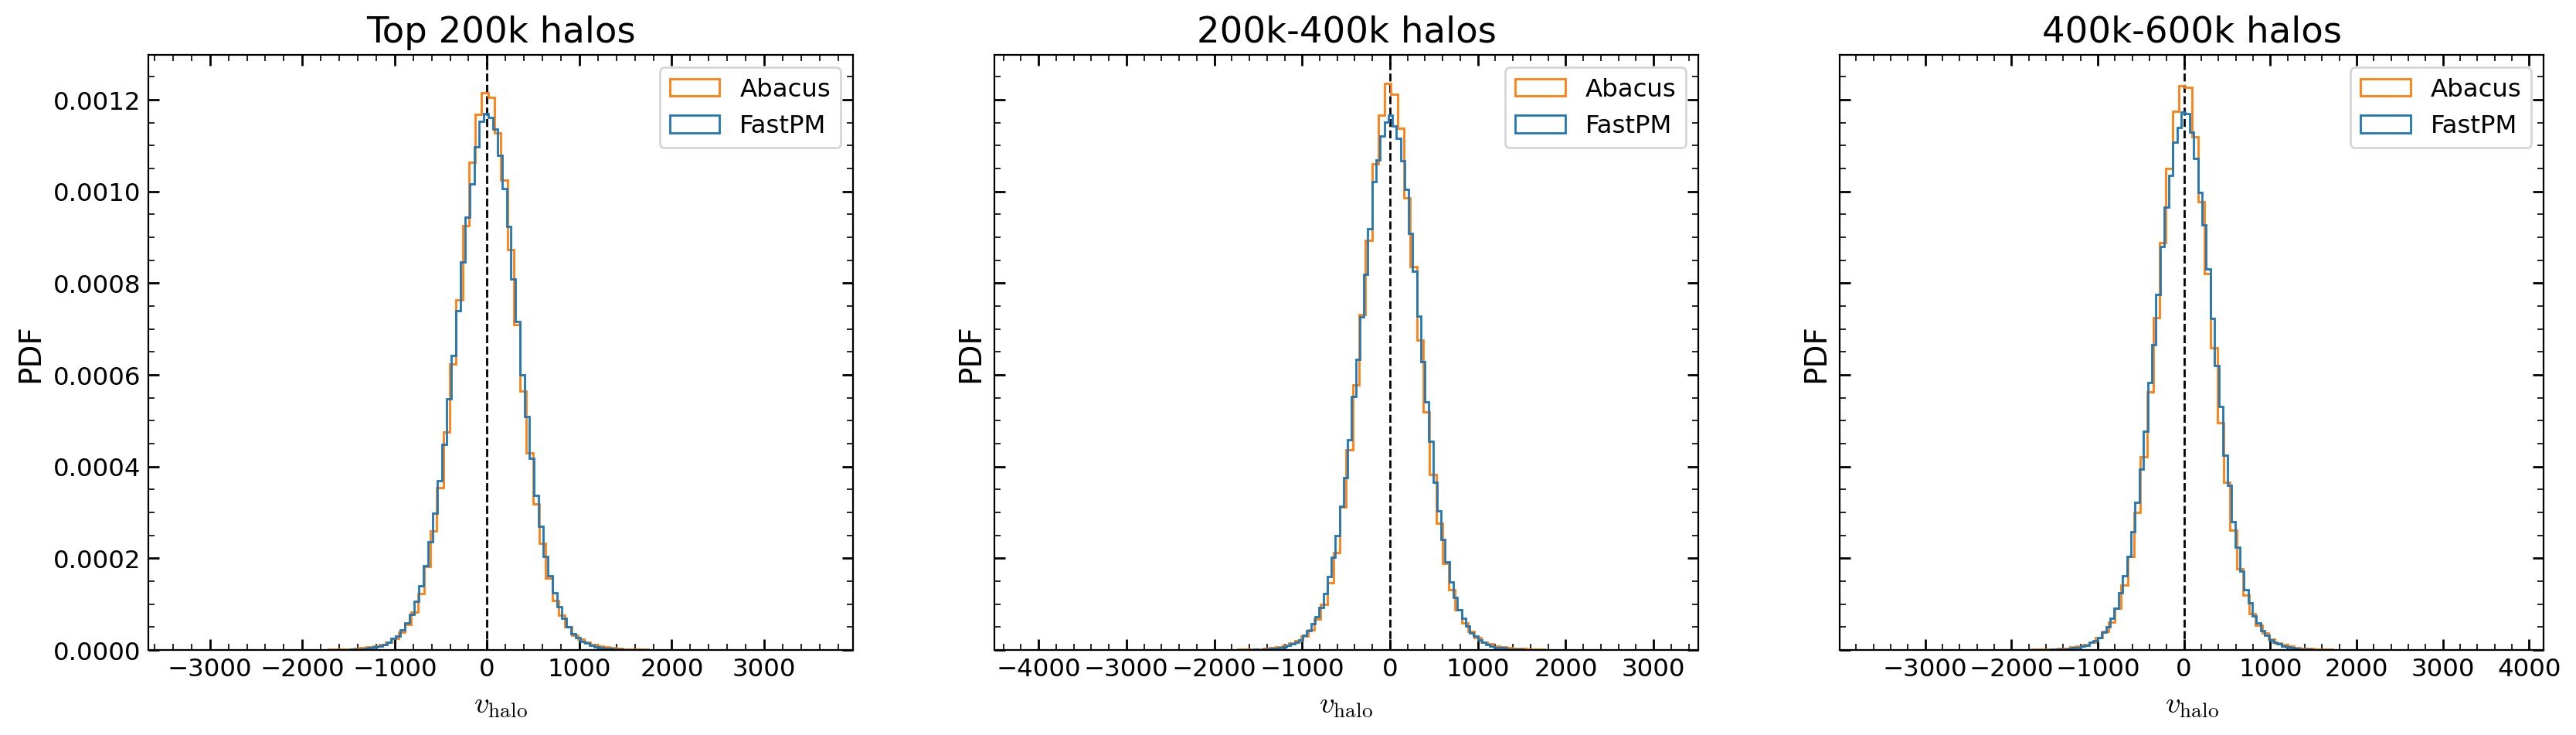

In [7]:
f, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

Nbin = 200_000
aidx = np.argsort(amass)
cidx = np.argsort(cmass)

h = 1  # 1.1  # 0.716500 # 1 # 0.673600 # 1 # 0.668800

xv = avel[aidx[-Nbin:]].flatten()
yv = cvel[cidx[-Nbin:]].flatten()/h
ax = axs[0]
ax.axvline(0, c='k', ls='--', lw=1)
ax.hist(xv, bins=100, histtype='step', color='C1',
        label='Abacus', lw=2, density=True)
ax.hist(yv, bins=100, histtype='step', color='C0',
        label='FastPM', lw=2, density=True)
ax.legend()
ax.set(xlabel=r'$v_{\rm halo}$', ylabel='PDF')
ax.set_title(f'Top 200k halos')

xv = avel[aidx[-2*Nbin:-Nbin]].flatten()
yv = cvel[cidx[-2*Nbin:-Nbin]].flatten()/h
ax = axs[1]
ax.axvline(0, c='k', ls='--', lw=1)
ax.hist(xv, bins=100, histtype='step', color='C1',
        label='Abacus', lw=2, density=True)
ax.hist(yv, bins=100, histtype='step', color='C0',
        label='FastPM', lw=2, density=True)
ax.legend()
ax.set(xlabel=r'$v_{\rm halo}$', ylabel='PDF')
ax.set_title(f'200k-400k halos')

xv = avel[aidx[-3*Nbin:-2*Nbin]].flatten()
yv = cvel[cidx[-3*Nbin:-2*Nbin]].flatten()/h
ax = axs[2]
ax.axvline(0, c='k', ls='--', lw=1)
ax.hist(xv, bins=100, histtype='step', color='C1',
        label='Abacus', lw=2, density=True)
ax.hist(yv, bins=100, histtype='step', color='C0',
        label='FastPM', lw=2, density=True)
ax.legend()
ax.set(xlabel=r'$v_{\rm halo}$', ylabel='PDF')
ax.set_title(f'400k-600k halos')

In [25]:
# quijote 1 gpc/h
filename = '/anvil/scratch/x-mho1/cmass-ili/quijote/nbody/L1000-N128/678/diag/halos.h5'
pdiag = {}
with h5py.File(filename, 'r') as f:
    for k, v in f['0.666667'].items():
        pdiag[k] = v[()]

filename = '/anvil/scratch/x-mho1/cmass-ili/abacus1gpch/correct/L1000-N128/136/diag/halos.h5'
adiag = {}
with h5py.File(filename, 'r') as f:
    for k, v in f['0.666667'].items():
        adiag[k] = v[()]


filename = '/anvil/scratch/x-mho1/cmass-ili/abacus/correct/L2000-N256/136/diag/halos.h5'
a2diag = {}
with h5py.File(filename, 'r') as f:
    for k, v in f['0.666667'].items():
        a2diag[k] = v[()]

print(adiag.keys())

dict_keys(['Bk', 'Bk_k123', 'Pk', 'Pk_k3D', 'Qk', 'bPk', 'bPk_k3D', 'mass_bins', 'mass_hist', 'zBk', 'zBk_k123', 'zPk', 'zPk_k3D', 'zQk', 'zbPk', 'zbPk_k3D'])


Text(0, 0.5, '$P_{\\rm abacus}$')

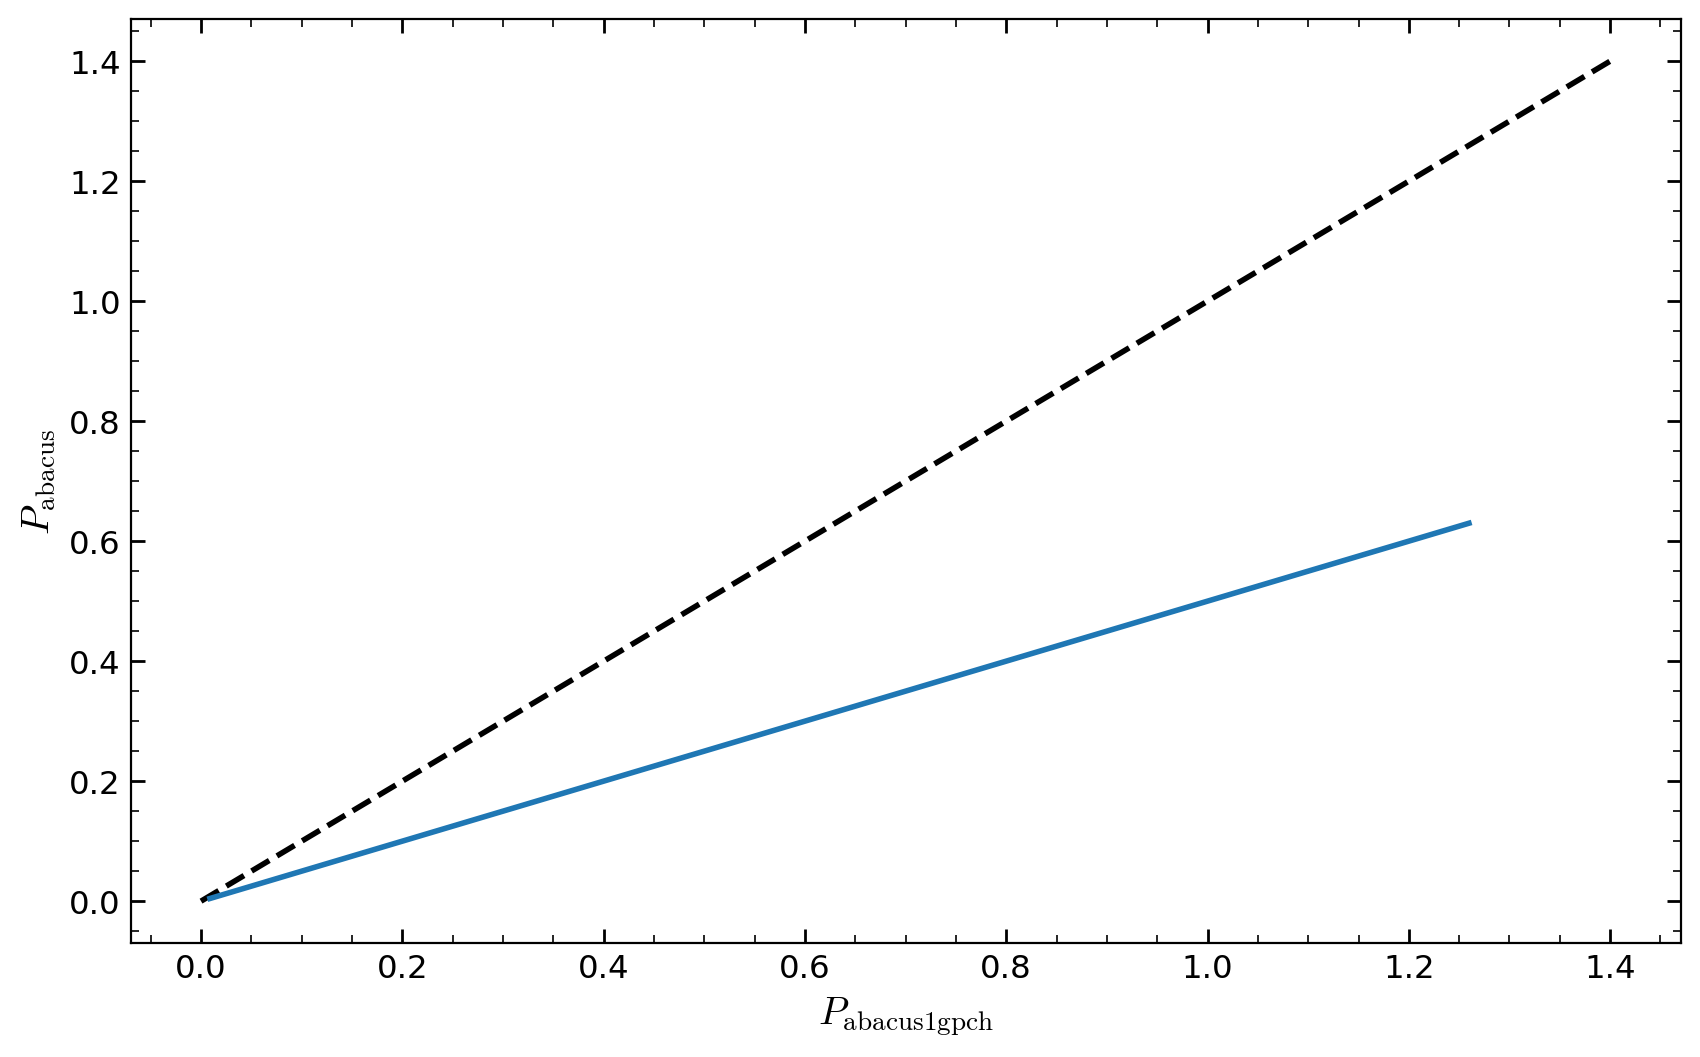

In [29]:
plt.plot([0, 1.4], [0, 1.4], 'k--')
plt.plot(adiag['Pk_k3D'][:200], a2diag['Pk_k3D'][:200])
plt.xlabel(r'$P_{\rm abacus1gpch}$')
plt.ylabel(r'$P_{\rm abacus}$')
# TODO: WTF? Are we sampling double the number of modes in the larger volume?

[Text(0.5, 0, 'k [h/Mpc]'), Text(0, 0.5, '$P_4(k)$')]

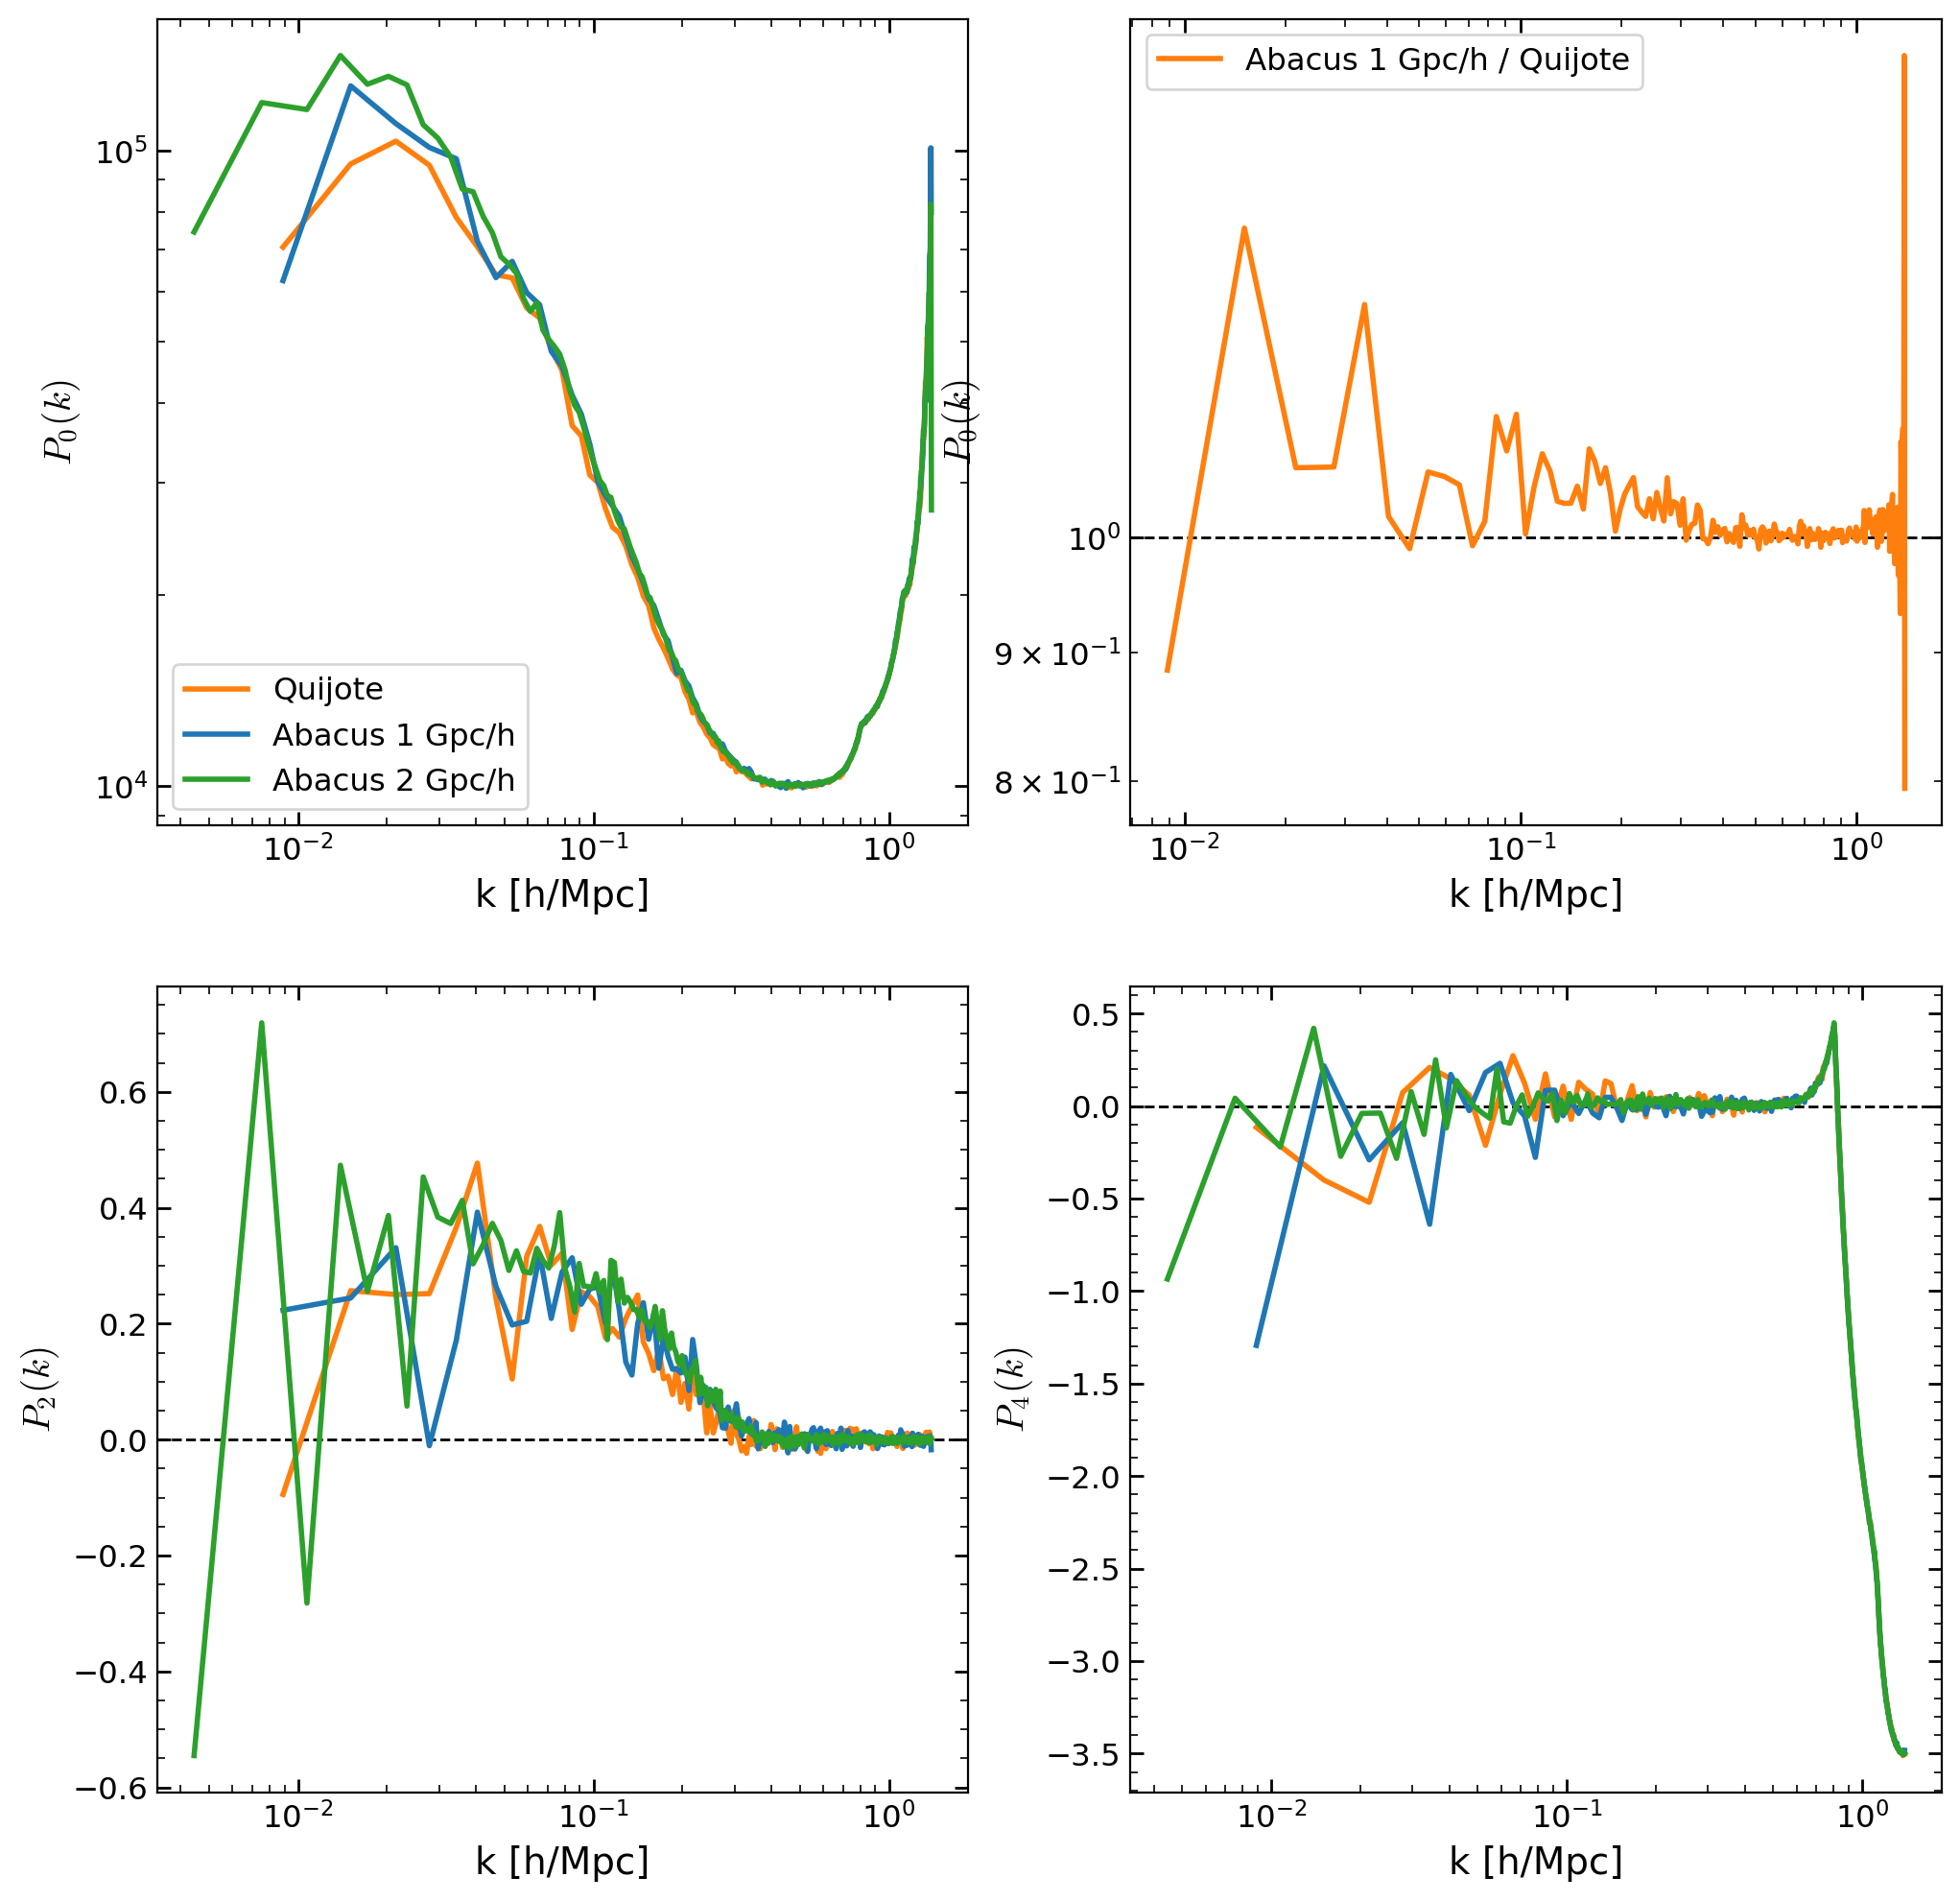

In [ ]:
f, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.flatten()
ax = axs[0]
ax.loglog()
ax.plot(pdiag['Pk_k3D'], pdiag['zPk'][:, 0], 'C1', lw=2, label='Quijote')
ax.plot(adiag['Pk_k3D'], adiag['zPk'][:, 0], 'C0', lw=2, label='Abacus 1 Gpc/h')
ax.plot(a2diag['Pk_k3D'], a2diag['zPk'][:, 0],
        'C2', lw=2, label='Abacus 2 Gpc/h')
ax.set(xlabel='k [h/Mpc]', ylabel=r'$P_0(k)$')
ax.legend()

ax = axs[1]
ax.loglog()
ax.axhline(1, c='k', ls='--', lw=1)
ax.plot(pdiag['Pk_k3D'], adiag['zPk'][:, 0]/pdiag['zPk']
        [:, 0], 'C1', lw=2, label='Abacus 1 Gpc/h / Quijote')
ax.set(xlabel='k [h/Mpc]', ylabel=r'$P_0(k)$')
ax.legend()

ax = axs[2]
ax.semilogx()
ax.axhline(0, c='k', ls='--', lw=1)
ax.plot(pdiag['Pk_k3D'], pdiag['zPk'][:, 1] /
        pdiag['zPk'][:, 0], 'C1', lw=2, label='Quijote')
ax.plot(adiag['Pk_k3D'], adiag['zPk'][:, 1]/adiag['zPk']
        [:, 0], 'C0', lw=2, label='Abacus 1 Gpc/h')
ax.plot(a2diag['Pk_k3D'], a2diag['zPk'][:, 1]/a2diag['zPk']
        [:, 0], 'C2', lw=2, label='Abacus 2 Gpc/h')
ax.set(xlabel='k [h/Mpc]', ylabel=r'$P_2(k)$')

ax = axs[3]
ax.semilogx()
ax.axhline(0, c='k', ls='--', lw=1)
ax.plot(pdiag['Pk_k3D'], pdiag['zPk'][:, 2] /
        pdiag['zPk'][:, 0], 'C1', lw=2, label='Quijote')
ax.plot(adiag['Pk_k3D'], adiag['zPk'][:, 2]/adiag['zPk']
        [:, 0], 'C0', lw=2, label='Abacus 1 Gpc/h')
ax.plot(a2diag['Pk_k3D'], a2diag['zPk'][:, 2]/a2diag['zPk']
        [:, 0], 'C2', lw=2, label='Abacus 2 Gpc/h')
ax.set(xlabel='k [h/Mpc]', ylabel=r'$P_4(k)$')

Text(0.5, 1.0, 'Quijote')

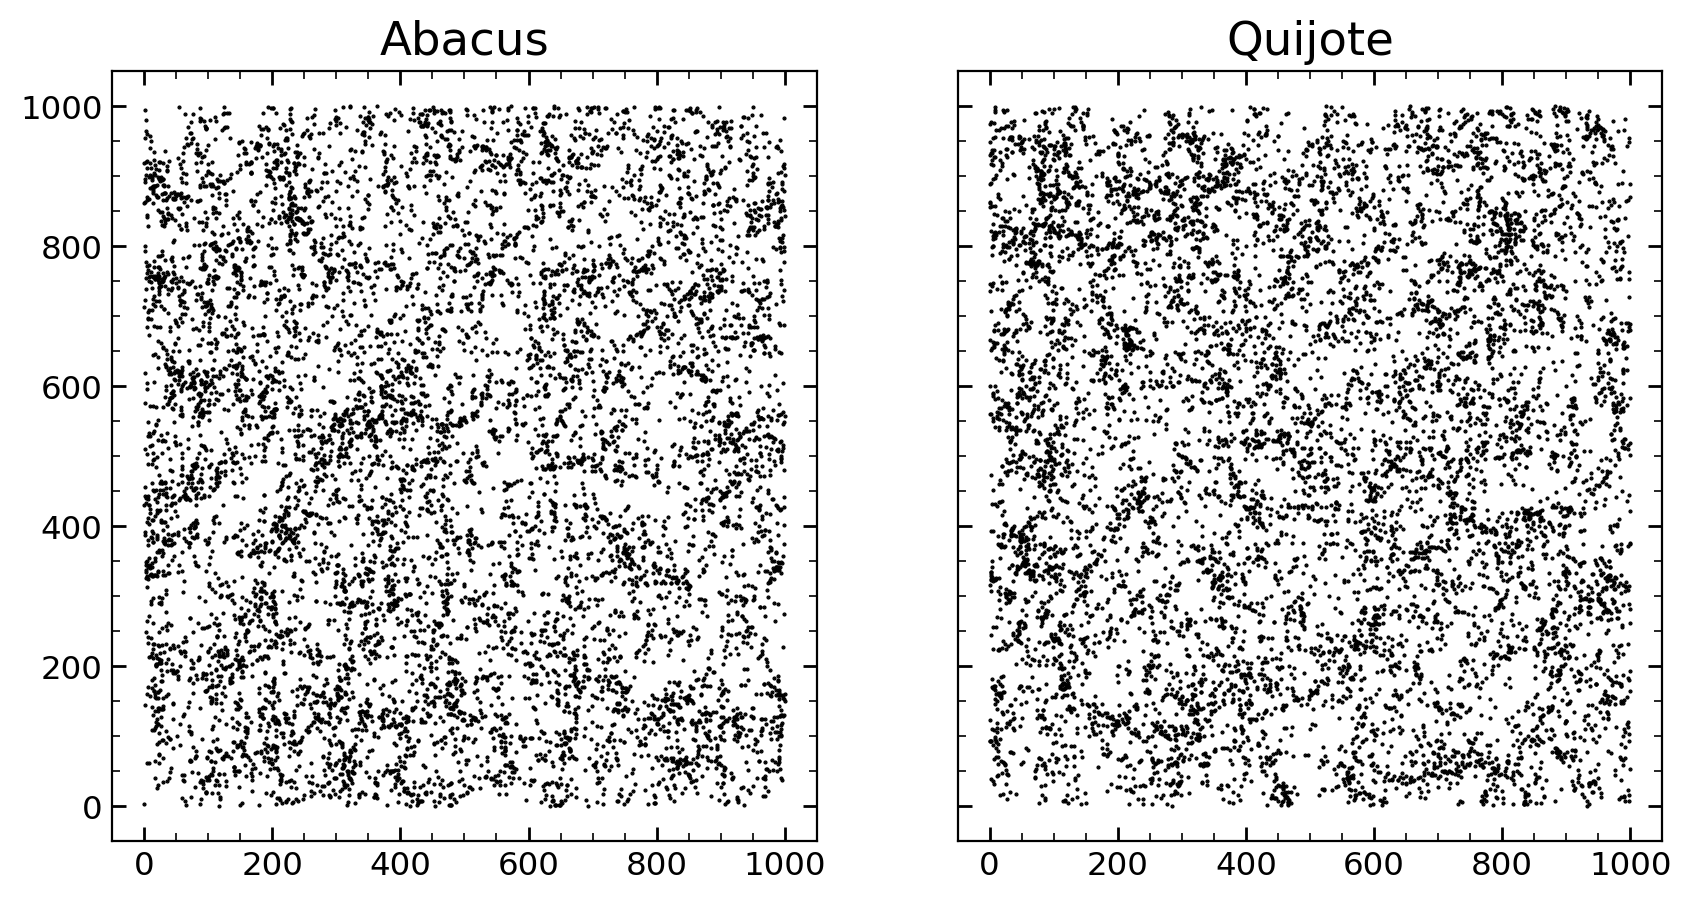

In [32]:
f, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

Nbin = 100_000
aidx = np.argsort(amass)
cidx = np.argsort(cmass)

x = apos[aidx[-Nbin:]]
y = cpos[cidx[-Nbin:]]

mask = x[:, 2] < 100
x = x[mask]
mask = y[:, 2] < 100
y = y[mask]

ax = axs[0]
ax.plot(x[:, 0], x[:, 1], 'k.', markersize=1, alpha=1)
ax.set_title('Abacus')

ax = axs[1]
ax.plot(y[:, 0], y[:, 1], 'k.', markersize=1, alpha=1)
ax.set_title('Quijote')

In [38]:
lhid = 132
filename = f'/anvil/scratch/x-mho1/cmass-ili/quijote/fastpm/L2000-N256/{lhid}/halos.h5'
filename = f'/anvil/scratch/x-mho1/cmass-ili/abacus1gpch/correct/L1000-N128/{lhid}/halos.h5'
# filename = f'/anvil/scratch/x-mho1/abacus/h5/{lhid}/halos.h5'
a = '0.666667'
with h5py.File(filename, 'r') as f:
    amass, apos, avel = f[a]['mass'][()], f[a]['pos'][()], f[a]['vel'][()]
    print(f'Loaded {lhid} with {len(amass)} halos')


filename = f'/anvil/scratch/x-mho1/cmass-ili/quijotelike/fastpm/L1000-N128/{lhid}/halos.h5'
a = '0.666667'
with h5py.File(filename, 'r') as f:
    cmass, cpos, cvel = f[a]['mass'][()], f[a]['pos'][()], f[a]['vel'][()]
    print(f'Loaded {lhid} with {len(cmass)} halos')

Loaded 132 with 1129835 halos
Loaded 132 with 578580 halos


Text(0.5, 1.0, 'FastPM')

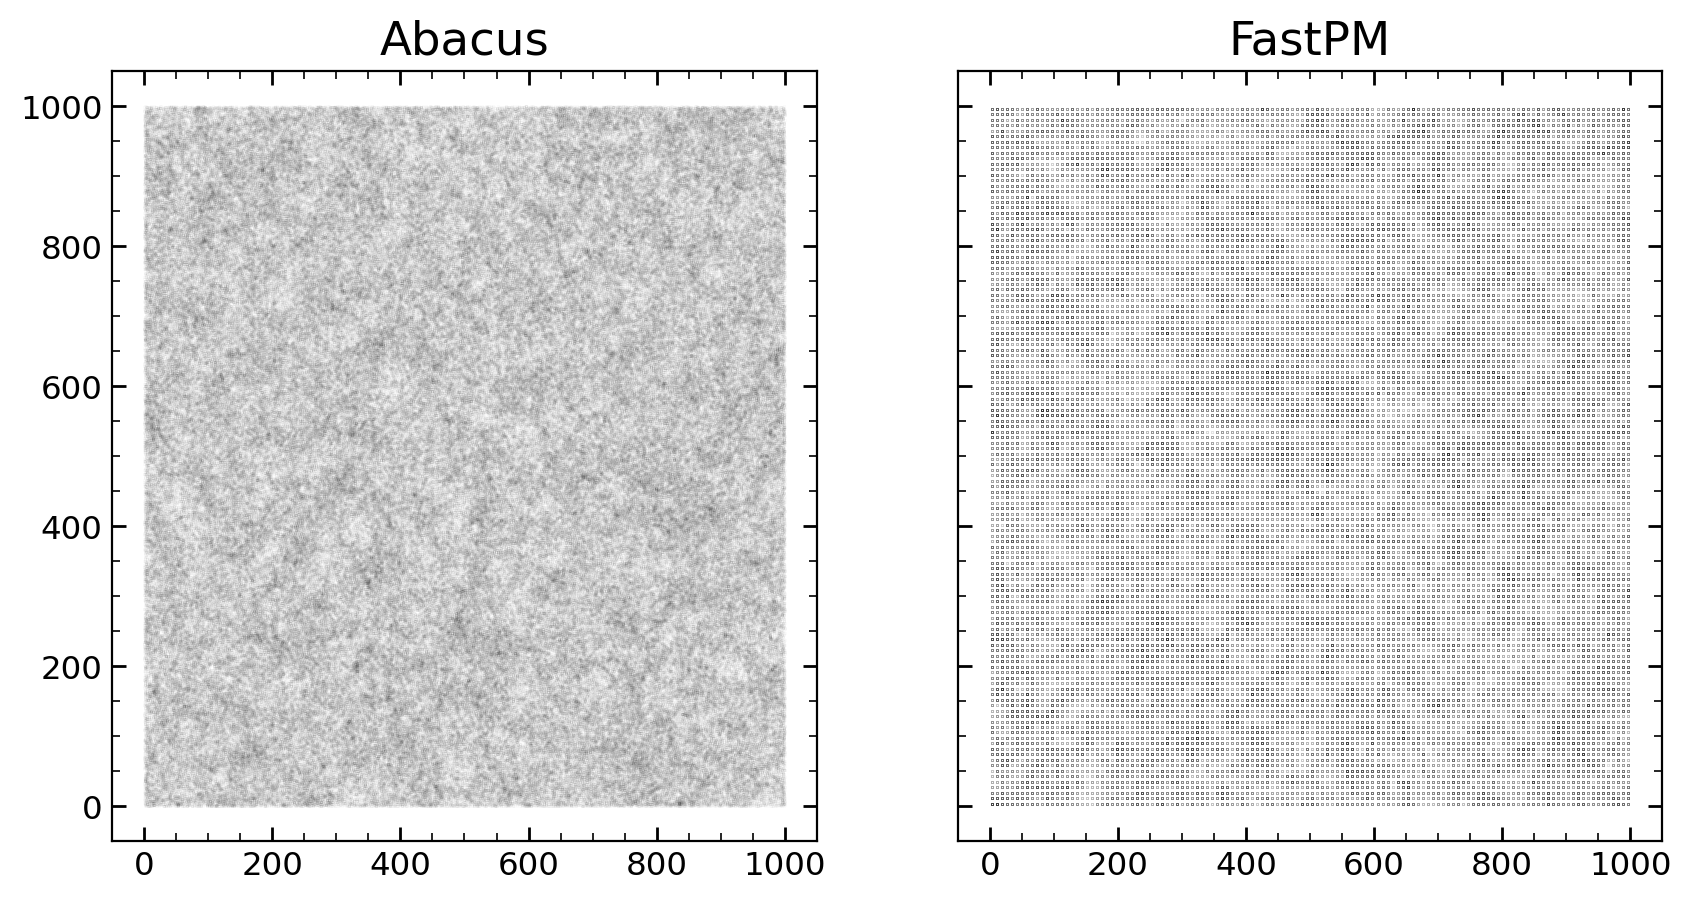

In [39]:
f, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=True)

Nbin = 800_000
aidx = np.argsort(amass)
cidx = np.argsort(cmass)

x = apos[aidx[-Nbin:]]
y = cpos[cidx[-Nbin:]]

ax = axs[0]
ax.plot(x[:, 0], x[:, 1], 'k.', markersize=0.1, alpha=0.1)
ax.set_title('Abacus')

ax = axs[1]
ax.plot(y[:, 0], y[:, 1], 'k.', markersize=0.1, alpha=0.1)
ax.set_title('FastPM')

## Predict across many

In [11]:
summaries = ['Pk0', 'Pk2']
tracer = 'halo'

In [13]:
# Load an observed summary
nbody = 'mtnglike'
sim = 'fastpm'
L, N = 3000, 384
lhid = 663
# summaries = ['Pk0', 'Pk2']

simpath = join(wdir, nbody, sim, f'L{L}-N{N}', f'{lhid}', 'diag')

summ = {}
with h5py.File(join(simpath, 'ngc_lightcone/hod06633_aug00000.h5'), 'r') as f:
    k = f['Pk_k3D'][:]
    for s in ['Pk0', 'Pk2', 'Pk4']:
        if s[:2] != 'Pk':
            raise NotImplementedError
        Pk = f['Pk'][:, int(s[-1])//2]  # get the pole
        summ[s] = [{'k': k, 'value': Pk}]
# a=f'{2/3:.6f}'
# with h5py.File(join(simpath, 'galaxies/hod20003.h5'), 'r') as f:
#     k = f[a]['Pk_k3D'][:]
#     for s in ['Pk0', 'Pk2', 'Pk4']:
#         if s[:2] != 'Pk':
#             raise NotImplementedError
#         Pk = f[a]['Pk'][:, int(s[-1])//2]  # get the pole
#         summ[s] = [{'k': k, 'value': Pk}]

#     truecosmo = f.attrs['cosmo_params']
#     truehod = f.attrs['HOD_params']
#     trueparams = np.concatenate([truecosmo, truehod])
# with h5py.File(join(simpath, 'halos.h5'), 'r') as f:
#     k = f[a]['Pk_k3D'][:]
#     for s in ['Pk0', 'Pk2', 'Pk4']:
#         if s[:2] != 'Pk':
#             raise NotImplementedError
#         Pk = f[a]['Pk'][:, int(s[-1])//2]  # get the pole
#         summ[s] = [{'k': k, 'value': Pk}]

#     truecosmo = f.attrs['cosmo_params']
#     # truehod = f.attrs['HOD_params']
#     trueparams = truecosmo # np.concatenate([truecosmo, truehod])

# truecosmo = [0.3175, 0.04900, 0.6711, 0.9624, 0.834]

In [98]:
from cmass.infer.loaders import preprocess_Pk


def load_and_predict(summaries=['Pk0', 'Pk2'], kmax=0.1):
    # Specify data dtype
    summary = '+'.join(summaries)
    modelpath = join(save_dir, tracer, summary, f'kmax-{kmax}')
    print(modelpath)

    # Load model posterior
    p = load_posterior(modelpath)

    # Load losses
    summary_file = join(modelpath, 'summary.json')
    with open(summary_file, 'r') as f:
        history = json.load(f)

    # Preprocess observations
    xin = []
    for s in summaries:
        if s == 'Pk0':
            xs = preprocess_Pk(summ[s], kmax, monopole=True)
        else:
            xs = preprocess_Pk(summ[s], kmax, monopole=False, norm=summ['Pk0'])
        xin.append(xs)
    xin = np.array(xin).flatten()
    print(xin.shape)

    # Predict
    sampobs = p.sample(x=xin, shape=(1000,)).to('cpu')
    return sampobs, history

INFO:root:Sampling models with [454, 546] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/halo/Pk0+Pk2/kmax-0.2
(190,)


Drawing 454 posterior samples: 822it [00:00, 17234.71it/s]            
Drawing 546 posterior samples: 792it [00:00, 51762.17it/s]            
INFO:root:Sampling models with [574, 426] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/halo/Pk0+Pk2/kmax-0.3
(284,)


Drawing 574 posterior samples: 1068it [00:00, 21323.31it/s]           
Drawing 426 posterior samples: 734it [00:00, 47748.30it/s]            
INFO:root:Sampling models with [595, 405] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/halo/Pk0+Pk2/kmax-0.4
(380,)


Drawing 595 posterior samples: 1085it [00:00, 20854.27it/s]           
Drawing 405 posterior samples: 645it [00:00, 40629.05it/s]            
INFO:root:Sampling models with [572, 428] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/halo/Pk0+Pk2/kmax-0.5
(476,)


Drawing 572 posterior samples: 909it [00:00, 16591.12it/s]            
Drawing 428 posterior samples: 689it [00:00, 39331.41it/s]            


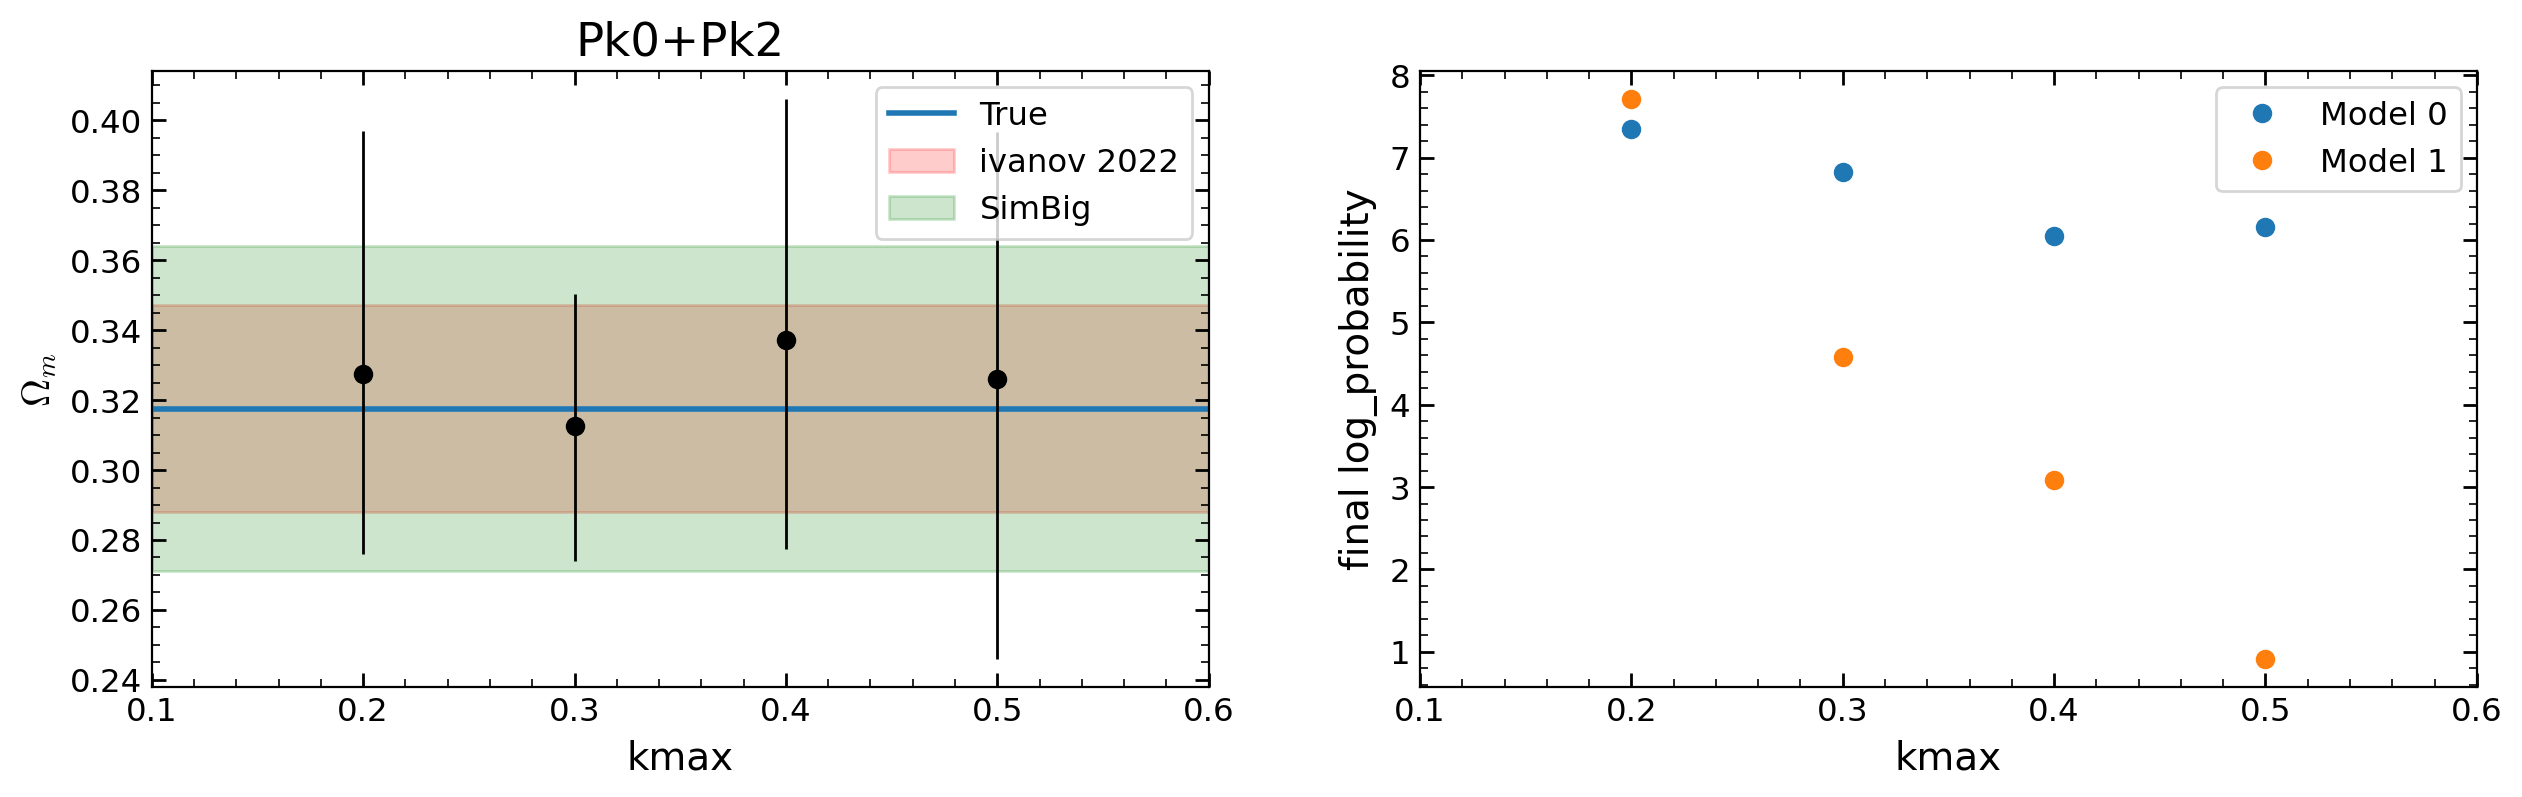

In [99]:
# Omega_m
pind = 0

f, axs = plt.subplots(1, 2, figsize=(15, 4), sharex=True)

ax = axs[0]
ax.axhline(trueparams[pind], color='C0', ls='-', label='True')
std = iva.iloc[:, pind].std()
ax.fill_between([0.1, 0.6],
                [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
                alpha=0.2, color='r', label='ivanov 2022')
std = sbpk.iloc[:, pind].std()
ax.fill_between([0.1, 0.6],
                [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
                alpha=0.2, color='g', label='SimBig')

ax2 = axs[1]

for k in [0.2, 0.3, 0.4, 0.5]:
    sampobs, hist = load_and_predict(summaries, kmax=k)

    # plot samples
    percs = np.percentile(sampobs, [16, 50, 84], axis=0)
    ax.plot(k, percs[1, pind], 'ko')
    ax.errorbar(k, percs[1, pind],
                yerr=[[percs[1, pind]-percs[0, pind]],
                      [percs[2, pind]-percs[1, pind]]],
                ecolor='k', elinewidth=1)

    # plot losses
    for j in range(len(hist)):
        ax2.plot(k, hist[j]['validation_log_probs'][-1], 'o',
                 label=f'Model {j}' if k == 0.2 else None,
                 c=f'C{j}')
ax.set(xlabel='kmax', ylabel=names[pind])
ax.legend()
ax.set_xlim(0.1, 0.6)
ax.set_title('+'.join(summaries))
ax2.set(xlabel='kmax', ylabel='final log_probability')
ax2.legend()

INFO:root:Sampling models with [454, 546] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/halo/Pk0+Pk2/kmax-0.2
(190,)


Drawing 454 posterior samples: 804it [00:00, 16848.89it/s]            
Drawing 546 posterior samples: 812it [00:00, 53452.43it/s]            
INFO:root:Sampling models with [574, 426] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/halo/Pk0+Pk2/kmax-0.3
(284,)


Drawing 574 posterior samples: 1057it [00:00, 21057.28it/s]           
Drawing 426 posterior samples: 742it [00:00, 48377.51it/s]            
INFO:root:Sampling models with [595, 405] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/halo/Pk0+Pk2/kmax-0.4
(380,)


Drawing 595 posterior samples: 1080it [00:00, 20798.77it/s]           
Drawing 405 posterior samples: 639it [00:00, 41265.61it/s]            
INFO:root:Sampling models with [572, 428] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/halo/Pk0+Pk2/kmax-0.5
(476,)


Drawing 572 posterior samples: 881it [00:00, 16950.14it/s]            
Drawing 428 posterior samples: 674it [00:00, 38542.81it/s]            


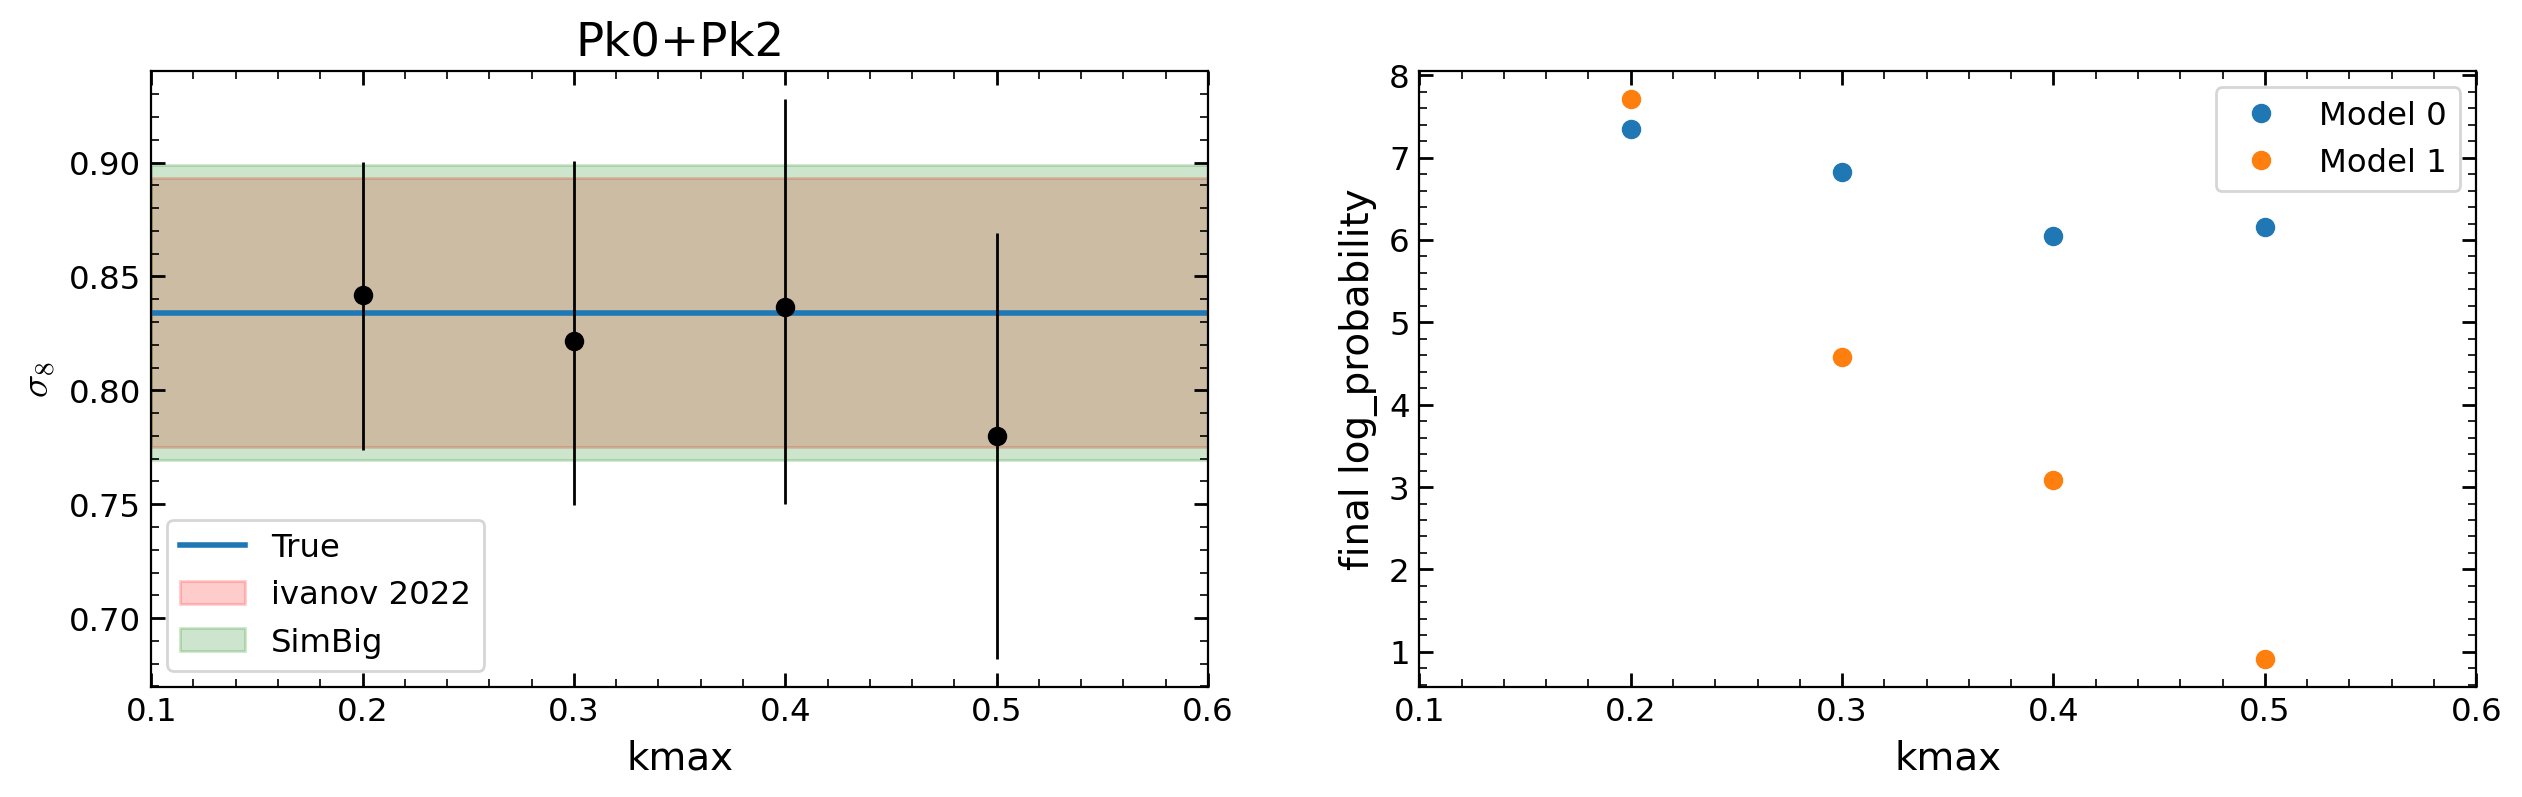

In [100]:
# sigma_8
pind = 4

f, axs = plt.subplots(1, 2, figsize=(15, 4), sharex=True)

ax = axs[0]
ax.axhline(trueparams[pind], color='C0', ls='-', label='True')
std = iva.iloc[:, pind].std()
ax.fill_between([0.1, 0.6],
                [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
                alpha=0.2, color='r', label='ivanov 2022')
std = sbpk.iloc[:, pind].std()
ax.fill_between([0.1, 0.6],
                [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
                alpha=0.2, color='g', label='SimBig')

ax2 = axs[1]

for k in [0.2, 0.3, 0.4, 0.5]:
    sampobs, hist = load_and_predict(summaries, kmax=k)

    # plot samples
    percs = np.percentile(sampobs, [16, 50, 84], axis=0)
    ax.plot(k, percs[1, pind], 'ko')
    ax.errorbar(k, percs[1, pind],
                yerr=[[percs[1, pind]-percs[0, pind]],
                      [percs[2, pind]-percs[1, pind]]],
                ecolor='k', elinewidth=1)

    # plot losses
    for j in range(len(hist)):
        ax2.plot(k, hist[j]['validation_log_probs'][-1], 'o',
                 label=f'Model {j}' if k == 0.2 else None,
                 c=f'C{j}')
ax.set(xlabel='kmax', ylabel=names[pind])
ax.legend()
ax.set_xlim(0.1, 0.6)
ax.set_title('+'.join(summaries))
ax2.set(xlabel='kmax', ylabel='final log_probability')
ax2.legend()

INFO:root:Sampling models with [853, 147] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0+Pk2/kmax-0.2
(220,)


Drawing 853 posterior samples: 1448it [00:00, 9827.72it/s]            
Drawing 147 posterior samples: 178it [00:00, 7498.63it/s]             
INFO:root:Sampling models with [812, 188] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0+Pk2/kmax-0.3
(332,)


Drawing 812 posterior samples: 1433it [00:00, 9898.45it/s]            
Drawing 188 posterior samples: 210it [00:00, 8101.43it/s]             


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0+Pk2/kmax-0.4


INFO:root:Sampling models with [895, 105] samples each.


(444,)


Drawing 895 posterior samples: 1699it [00:00, 10981.85it/s]           
Drawing 105 posterior samples: 145it [00:00, 4002.70it/s]             

/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0+Pk2/kmax-0.5



INFO:root:Sampling models with [953, 47] samples each.


(556,)


Drawing 953 posterior samples: 1811it [00:00, 11282.25it/s]           
Drawing 47 posterior samples: 66it [00:00, 1959.61it/s]             


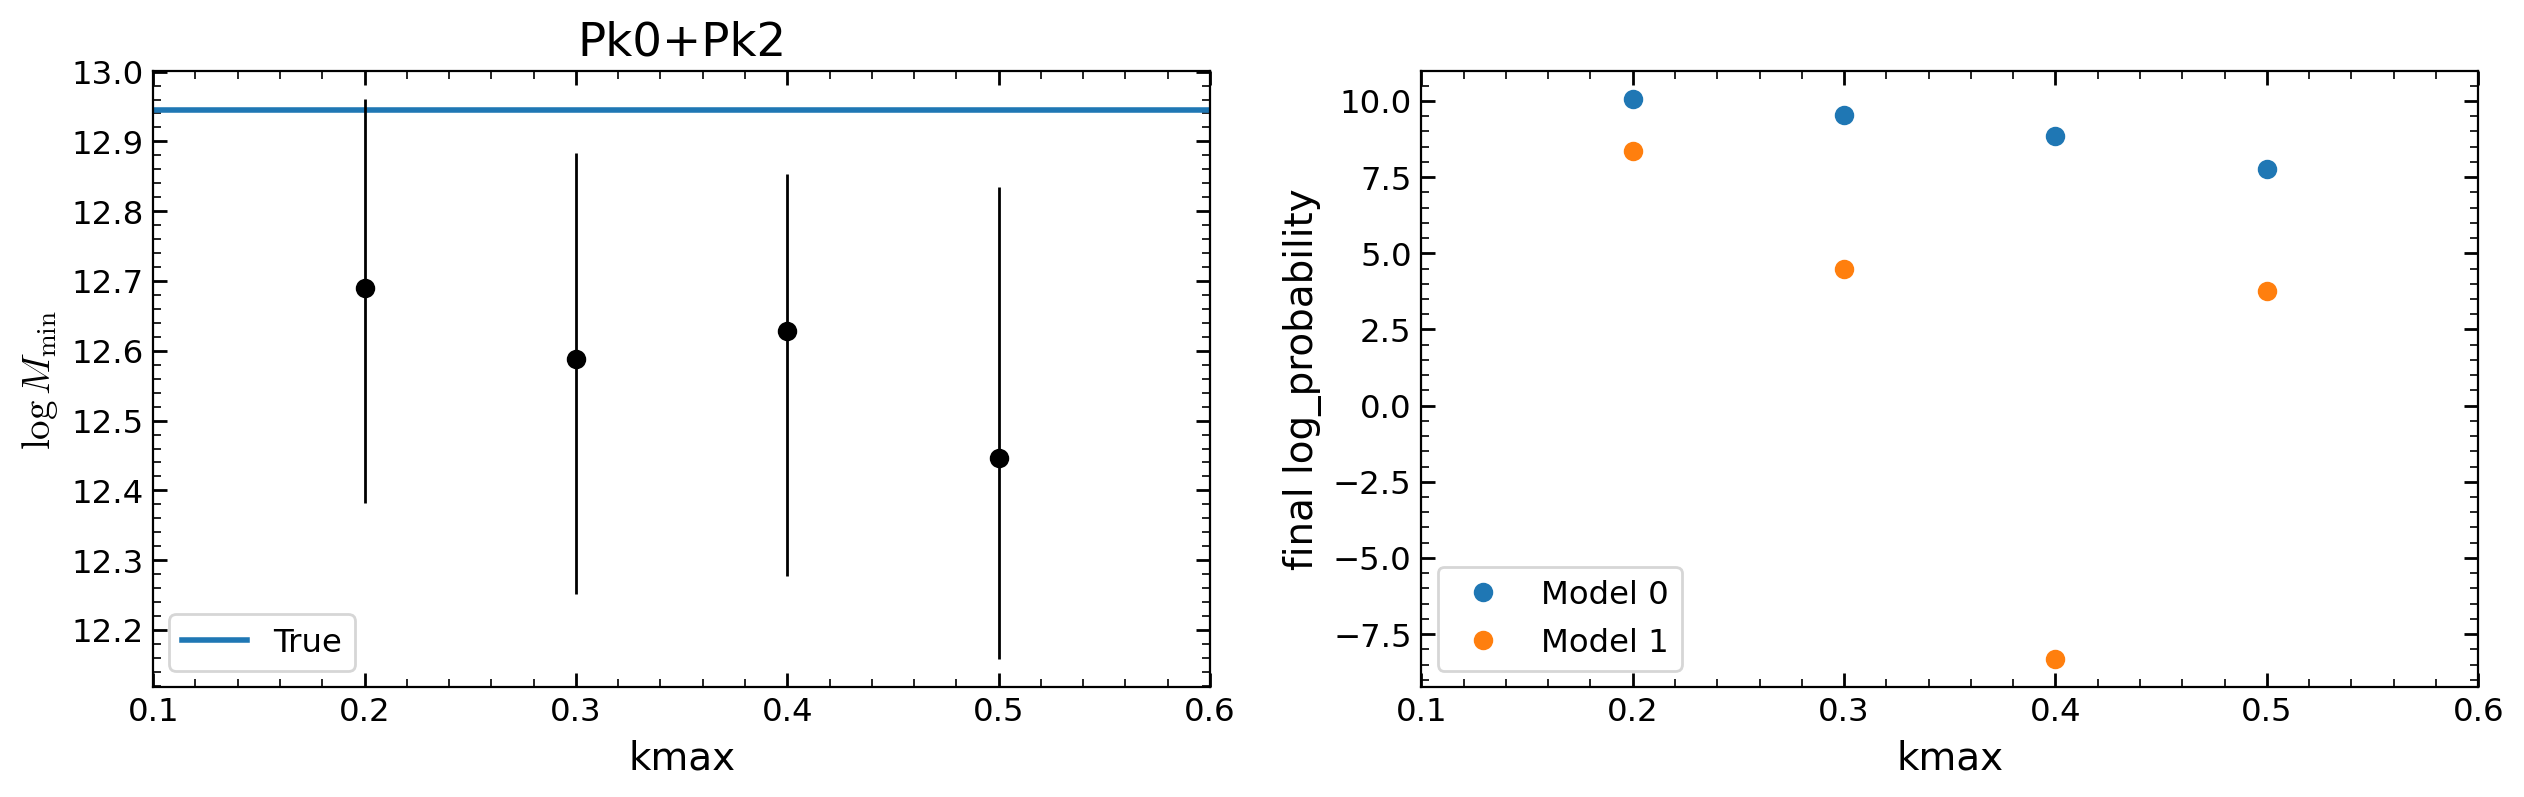

In [67]:
# logMmin
pind = 8

f, axs = plt.subplots(1, 2, figsize=(15, 4), sharex=True)

ax = axs[0]
ax.axhline(trueparams[pind], color='C0', ls='-', label='True')
# std = iva.iloc[:,pind].std()
# ax.fill_between([0.1, 0.6],
#                 [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
#                 alpha=0.2, color='r', label='ivanov 2022')
# std = sbpk.iloc[:,pind].std()
# ax.fill_between([0.1, 0.6],
#                 [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
#                 alpha=0.2, color='g', label='SimBig')

ax2 = axs[1]

for k in [0.2, 0.3, 0.4, 0.5]:
    sampobs, hist = load_and_predict(summaries, kmax=k)

    # plot samples
    percs = np.percentile(sampobs, [16, 50, 84], axis=0)
    ax.plot(k, percs[1, pind], 'ko')
    ax.errorbar(k, percs[1, pind],
                yerr=[[percs[1, pind]-percs[0, pind]],
                      [percs[2, pind]-percs[1, pind]]],
                ecolor='k', elinewidth=1)

    # plot losses
    for j in range(len(hist)):
        ax2.plot(k, hist[j]['validation_log_probs'][-1], 'o',
                 label=f'Model {j}' if k == 0.2 else None,
                 c=f'C{j}')
ax.set(xlabel='kmax', ylabel=names[pind])
ax.legend()
ax.set_xlim(0.1, 0.6)
ax.set_title('+'.join(summaries))
ax2.set(xlabel='kmax', ylabel='final log_probability')
ax2.legend()

NameError: name 'trueparams' is not defined

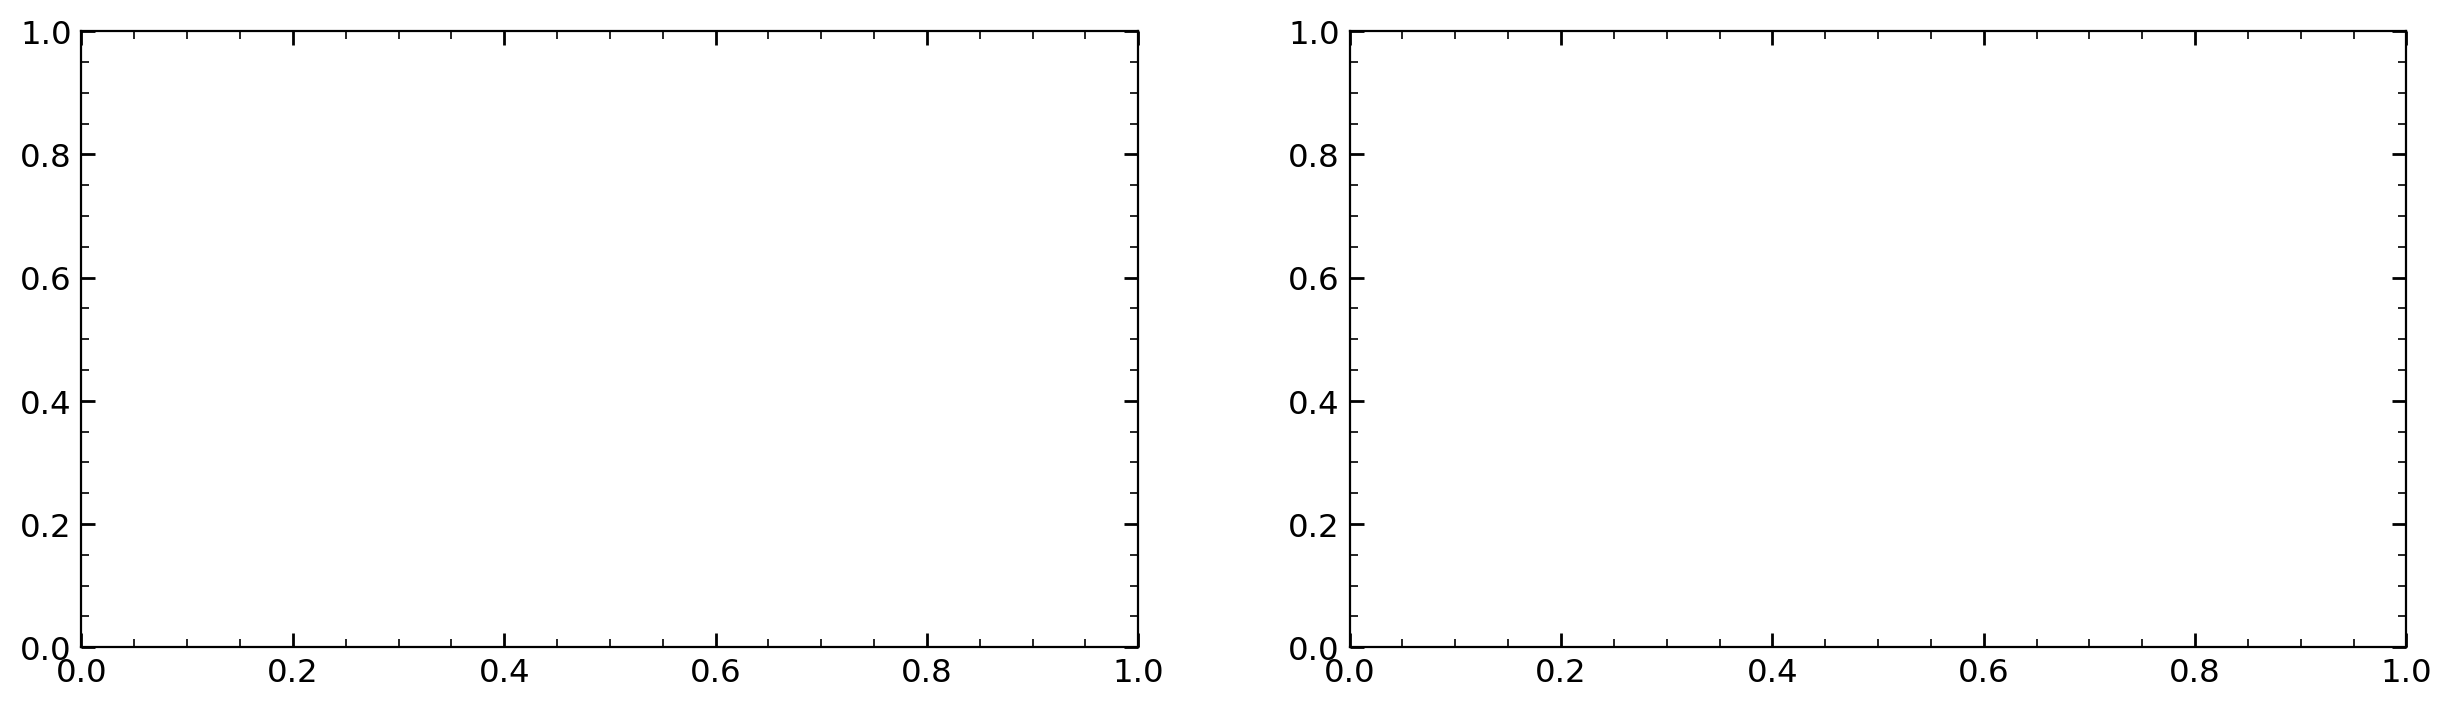

In [ ]:
# Omega_m
pind = 0

f, axs = plt.subplots(1, 2, figsize=(15, 4), sharex=True)

ax = axs[0]
ax.axhline(trueparams[pind], color='C0', ls='-', label='True')
std = iva.iloc[:, pind].std()
ax.fill_between([-1, 3],
                [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
                alpha=0.2, color='r', label='ivanov 2022')
std = sbpk.iloc[:, pind].std()
ax.fill_between([-1, 3],
                [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
                alpha=0.2, color='g', label='SimBig')

ax2 = axs[1]

slist = [['Pk0', 'Pk2'], ['Pk0', 'Pk2', 'Qk0']]
for i, s in enumerate(slist):
    k = 0.4
    sampobs, hist = load_and_predict(s, kmax=k)

    # plot samples
    percs = np.percentile(sampobs, [16, 50, 84], axis=0)
    ax.plot(i, percs[1, pind], 'ko')
    ax.errorbar(i, percs[1, pind],
                yerr=[[percs[1, pind]-percs[0, pind]],
                      [percs[2, pind]-percs[1, pind]]],
                ecolor='k', elinewidth=1)

    # plot losses
    for j in range(len(hist)):
        y = hist[j]['validation_log_probs'][-1]
        if y > -10:
            ax2.plot(i, y, 'o',
                     label=f'Model {j}' if k == 0.2 else None,
                     c=f'C{j}')
ax.set(xlabel='summary', ylabel=names[pind])
ax.legend()
ax.set_xlim(-1, 3)
ax.set_xticks(range(len(slist)))
ax.set_xticklabels(['+'.join(s) for s in slist])
ax.set_title(f'kmax={k}')
ax2.set(xlabel='summary', ylabel='final log_probability')
ax2.legend()

INFO:root:Sampling models with [874, 126] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0/kmax-0.4
(222,)


Drawing 874 posterior samples: 1372it [00:00, 8680.19it/s]            
Drawing 126 posterior samples: 128it [00:00, 3677.93it/s]             
INFO:root:Sampling models with [895, 105] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0+Pk2/kmax-0.4
(444,)


Drawing 895 posterior samples: 1714it [00:00, 10559.12it/s]           
Drawing 105 posterior samples: 136it [00:00, 3783.69it/s]             
INFO:root:Sampling models with [1000, 0] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0+Pk2+Pk4/kmax-0.4
(666,)


Drawing 1000 posterior samples: 1674it [00:00, 9345.91it/s]             


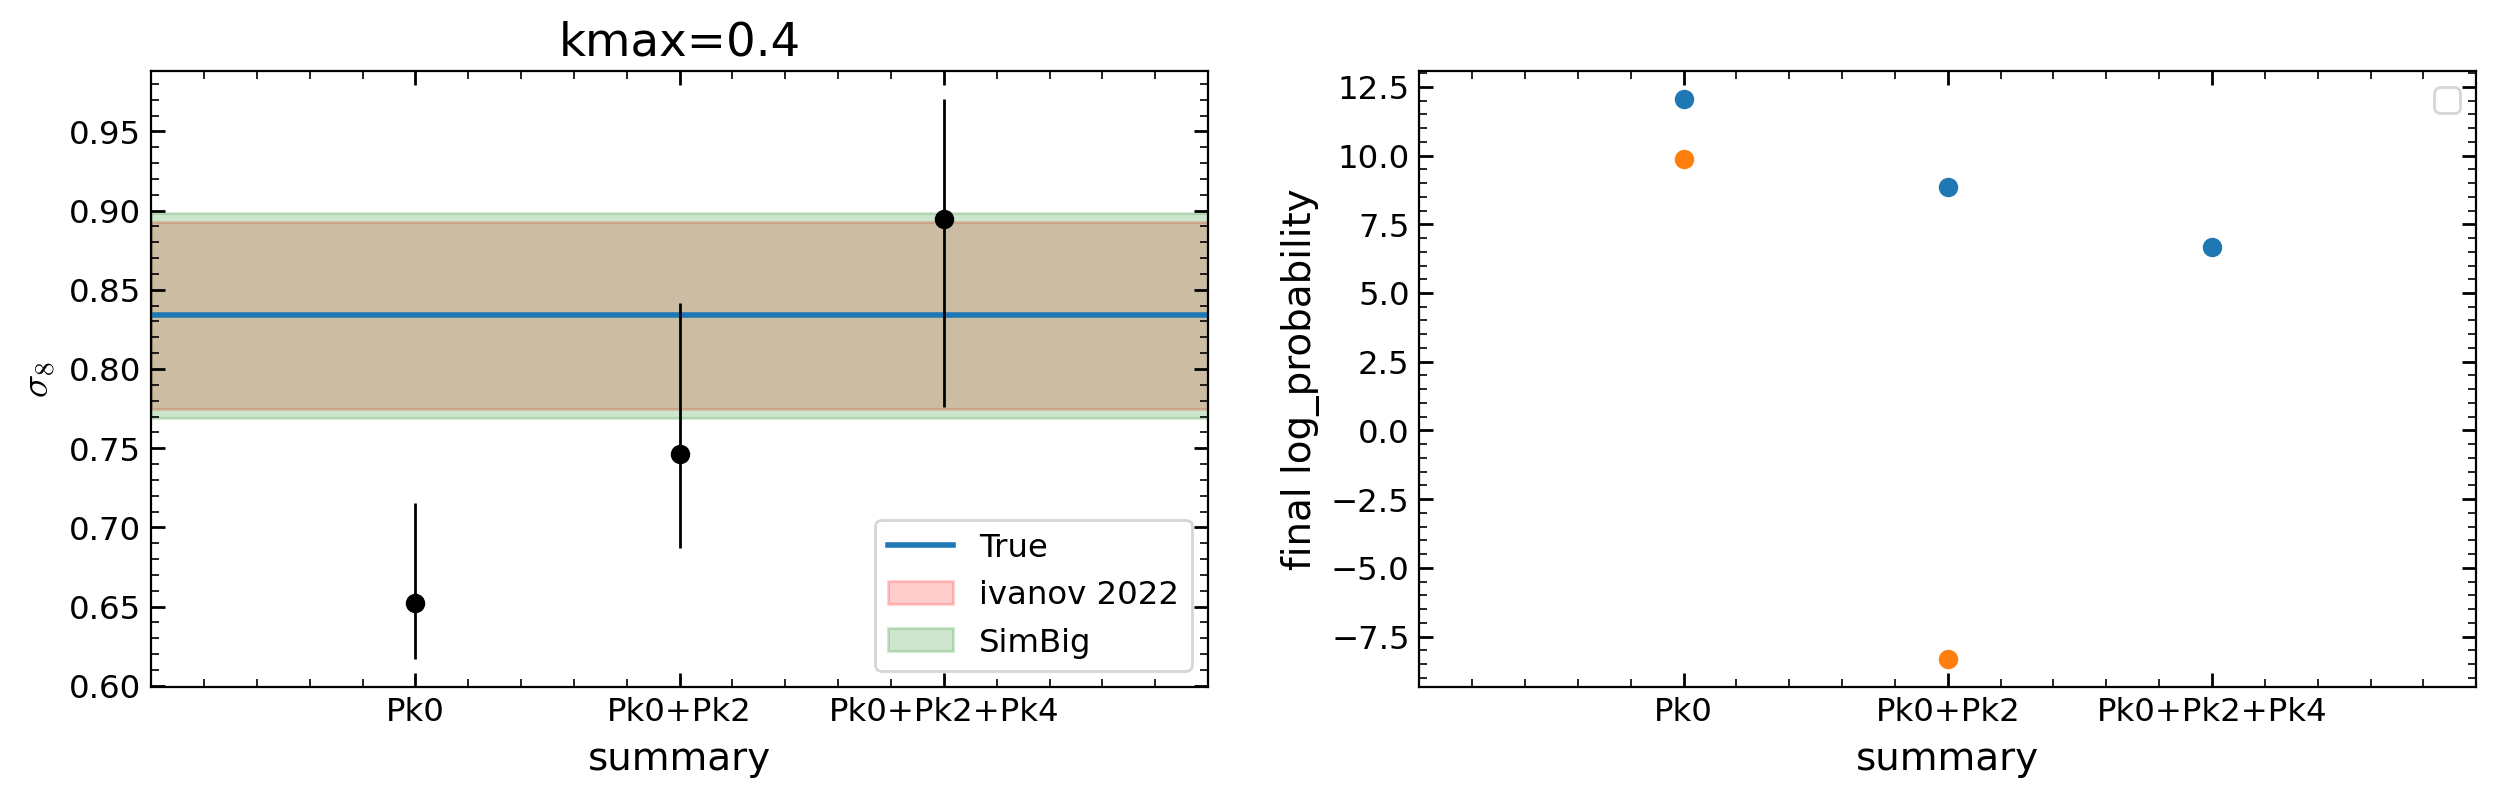

In [77]:
# sigma8
pind = 4

f, axs = plt.subplots(1, 2, figsize=(15, 4), sharex=True)

ax = axs[0]
ax.axhline(trueparams[pind], color='C0', ls='-', label='True')
std = iva.iloc[:, pind].std()
ax.fill_between([-1, 3],
                [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
                alpha=0.2, color='r', label='ivanov 2022')
std = sbpk.iloc[:, pind].std()
ax.fill_between([-1, 3],
                [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
                alpha=0.2, color='g', label='SimBig')

ax2 = axs[1]

slist = [['Pk0'], ['Pk0', 'Pk2'], ['Pk0', 'Pk2', 'Pk4']]
for i, s in enumerate(slist):
    k = 0.4
    sampobs, hist = load_and_predict(s, kmax=k)

    # plot samples
    percs = np.percentile(sampobs, [16, 50, 84], axis=0)
    ax.plot(i, percs[1, pind], 'ko')
    ax.errorbar(i, percs[1, pind],
                yerr=[[percs[1, pind]-percs[0, pind]],
                      [percs[2, pind]-percs[1, pind]]],
                ecolor='k', elinewidth=1)

    # plot losses
    for j in range(len(hist)):
        y = hist[j]['validation_log_probs'][-1]
        if y > -10:
            ax2.plot(i, y, 'o',
                     label=f'Model {j}' if k == 0.2 else None,
                     c=f'C{j}')
ax.set(xlabel='summary', ylabel=names[pind])
ax.legend()
ax.set_xlim(-1, 3)
ax.set_xticks(range(len(slist)))
ax.set_xticklabels(['+'.join(s) for s in slist])
ax.set_title(f'kmax={k}')
ax2.set(xlabel='summary', ylabel='final log_probability')
ax2.legend()

INFO:root:Sampling models with [874, 126] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0/kmax-0.4
(222,)


Drawing 874 posterior samples: 1362it [00:00, 9113.50it/s]            
Drawing 126 posterior samples:  89%|████████▉ | 112/126 [00:00<00:00, 3231.34it/s]
INFO:root:Sampling models with [895, 105] samples each.


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0+Pk2/kmax-0.4
(444,)


Drawing 895 posterior samples: 1707it [00:00, 10855.35it/s]           
Drawing 105 posterior samples: 110it [00:00, 4678.44it/s]             


/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/models/ngc_lightcone/Pk0+Pk2+Pk4/kmax-0.4


INFO:root:Sampling models with [1000, 0] samples each.


(666,)


Drawing 1000 posterior samples: 1709it [00:00, 9988.34it/s]             


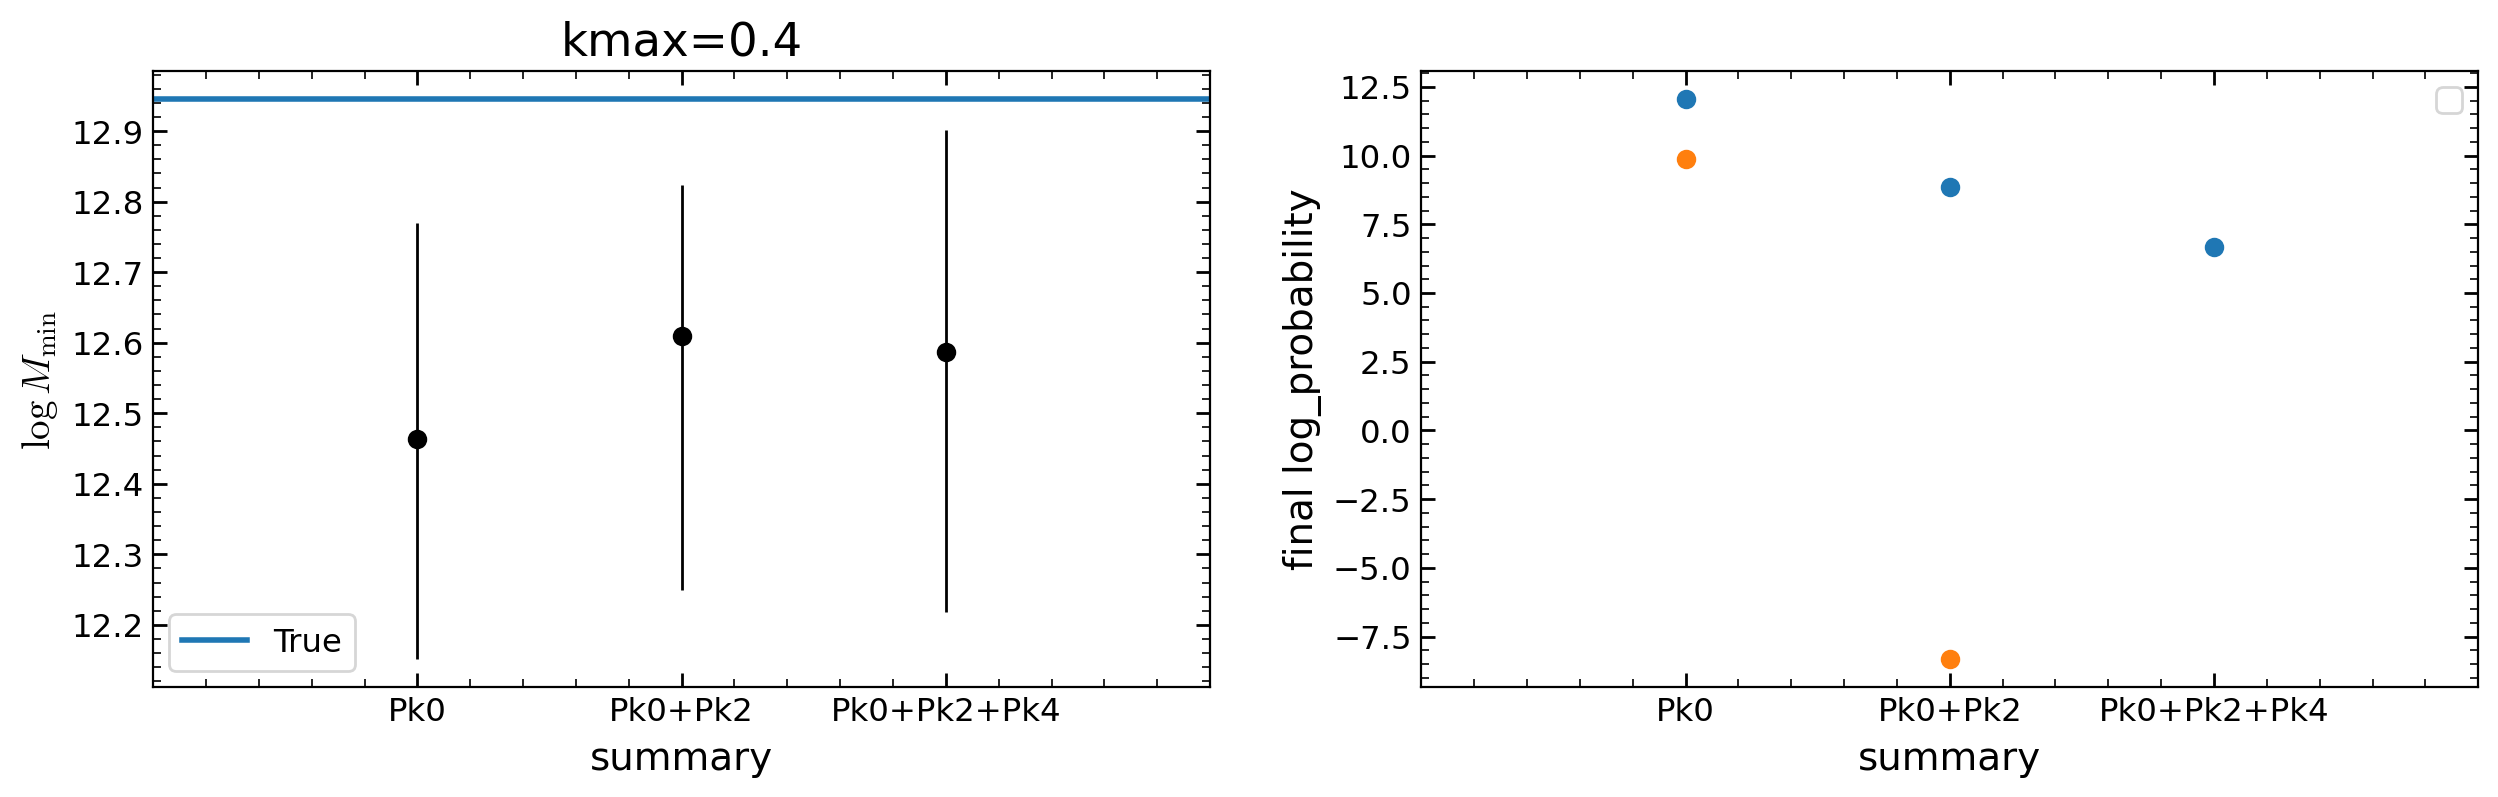

In [80]:
# logMmin
pind = 8

f, axs = plt.subplots(1, 2, figsize=(15, 4), sharex=True)

ax = axs[0]
ax.axhline(trueparams[pind], color='C0', ls='-', label='True')
# std = iva.iloc[:,pind].std()
# ax.fill_between([-1, 3],
#                 [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
#                 alpha=0.2, color='r', label='ivanov 2022')
# std = sbpk.iloc[:,pind].std()
# ax.fill_between([-1, 3],
#                 [trueparams[pind]-std]*2, [trueparams[pind] + std]*2,
#                 alpha=0.2, color='g', label='SimBig')

ax2 = axs[1]

slist = [['Pk0'], ['Pk0', 'Pk2'], ['Pk0', 'Pk2', 'Pk4']]
for i, s in enumerate(slist):
    k = 0.4
    sampobs, hist = load_and_predict(s, kmax=k)

    # plot samples
    percs = np.percentile(sampobs, [16, 50, 84], axis=0)
    ax.plot(i, percs[1, pind], 'ko')
    ax.errorbar(i, percs[1, pind],
                yerr=[[percs[1, pind]-percs[0, pind]],
                      [percs[2, pind]-percs[1, pind]]],
                ecolor='k', elinewidth=1)

    # plot losses
    for j in range(len(hist)):
        y = hist[j]['validation_log_probs'][-1]
        if y > -10:
            ax2.plot(i, y, 'o',
                     label=f'Model {j}' if k == 0.2 else None,
                     c=f'C{j}')
ax.set(xlabel='summary', ylabel=names[pind])
ax.legend()
ax.set_xlim(-1, 3)
ax.set_xticks(range(len(slist)))
ax.set_xticklabels(['+'.join(s) for s in slist])
ax.set_title(f'kmax={k}')
ax2.set(xlabel='summary', ylabel='final log_probability')
ax2.legend()

## Measure constraining power

## Scratch

Text(0.5, 1.0, 'Smoothbox')

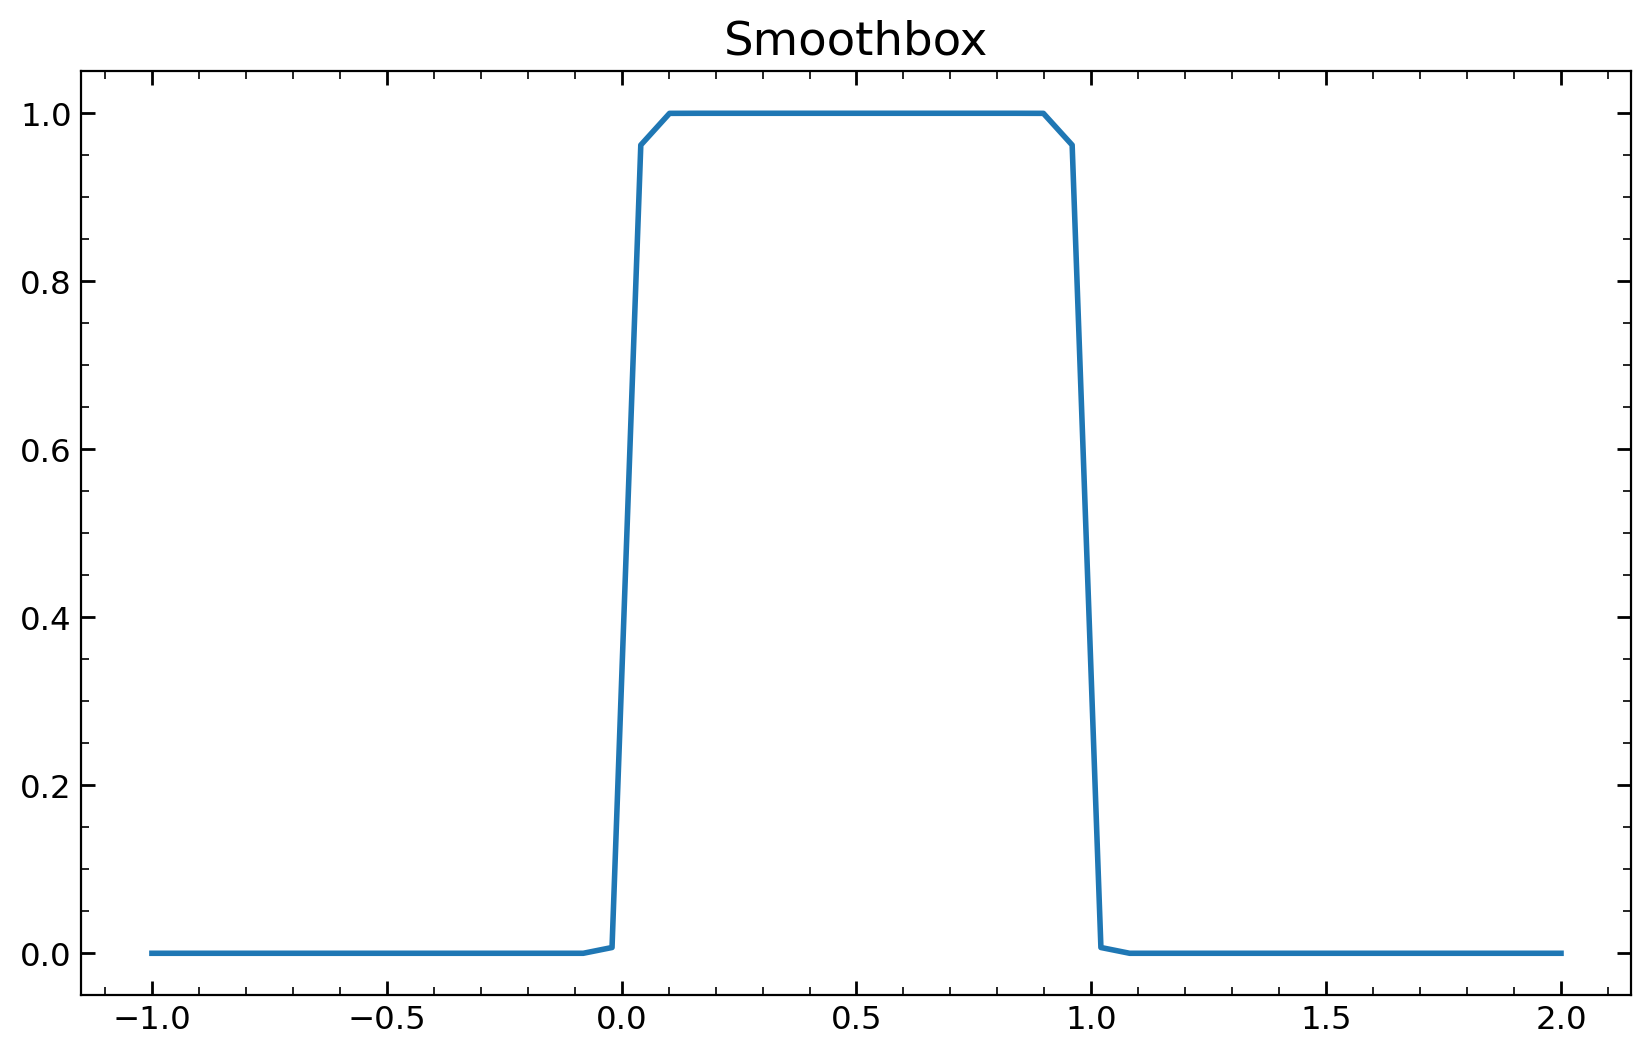

In [ ]:
import torch


def smoothbox_log_prob(x, a=0.0, b=1.0, k=50.0):
    return torch.log(torch.sigmoid(k * (x - a))) + torch.log(torch.sigmoid(k * (b - x)))


x = torch.linspace(-1, 2, 50)
y = smoothbox_log_prob(x, a=0., b=1, k=100)
plt.plot(x, 10**y)
plt.title('Smoothbox')

Text(0.5, 1.0, 'Gaussian+Uniform')

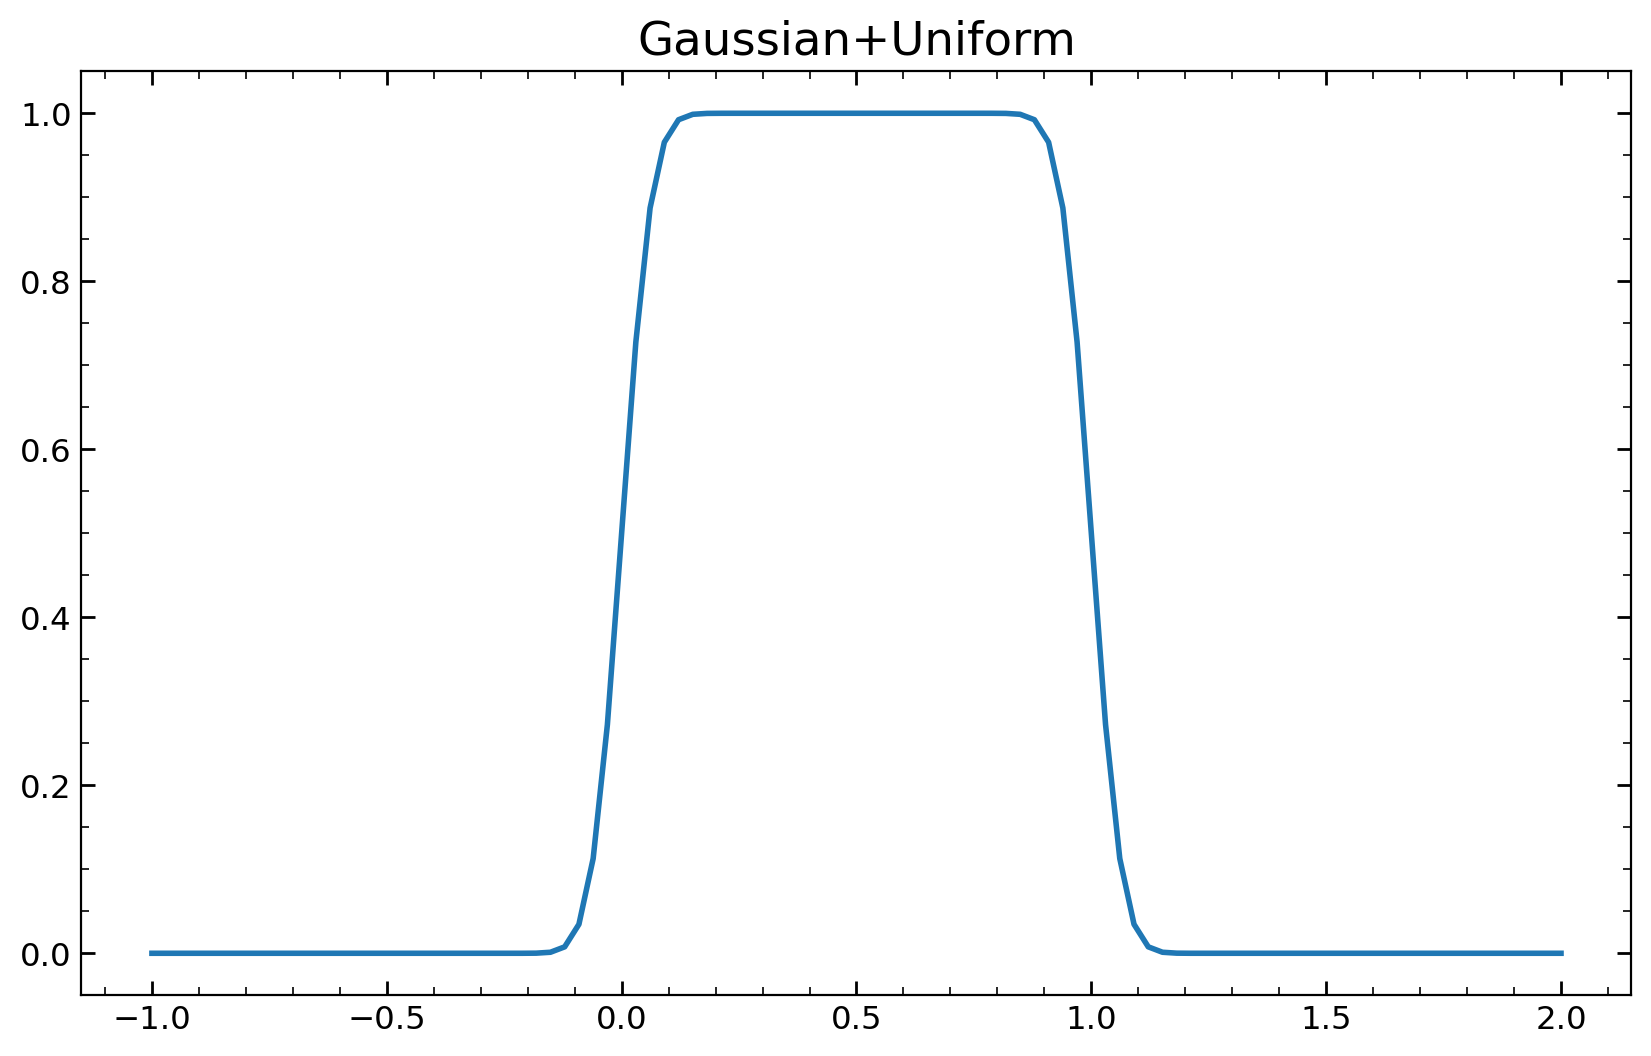

In [ ]:
from scipy.stats import norm
import numpy as np


def smooth_uniform_pdf(x, a=0.0, b=1.0, sigma=0.05):
    return (norm.cdf((x - a)/sigma) - norm.cdf((x - b)/sigma)) / (b - a)


x = np.linspace(-1, 2, 100)
y = smooth_uniform_pdf(x, a=0., b=1, sigma=0.05)
plt.plot(x, y)
plt.title('Gaussian+Uniform')

Text(0.5, 1.0, 'Gaussian+Uniform CDF')

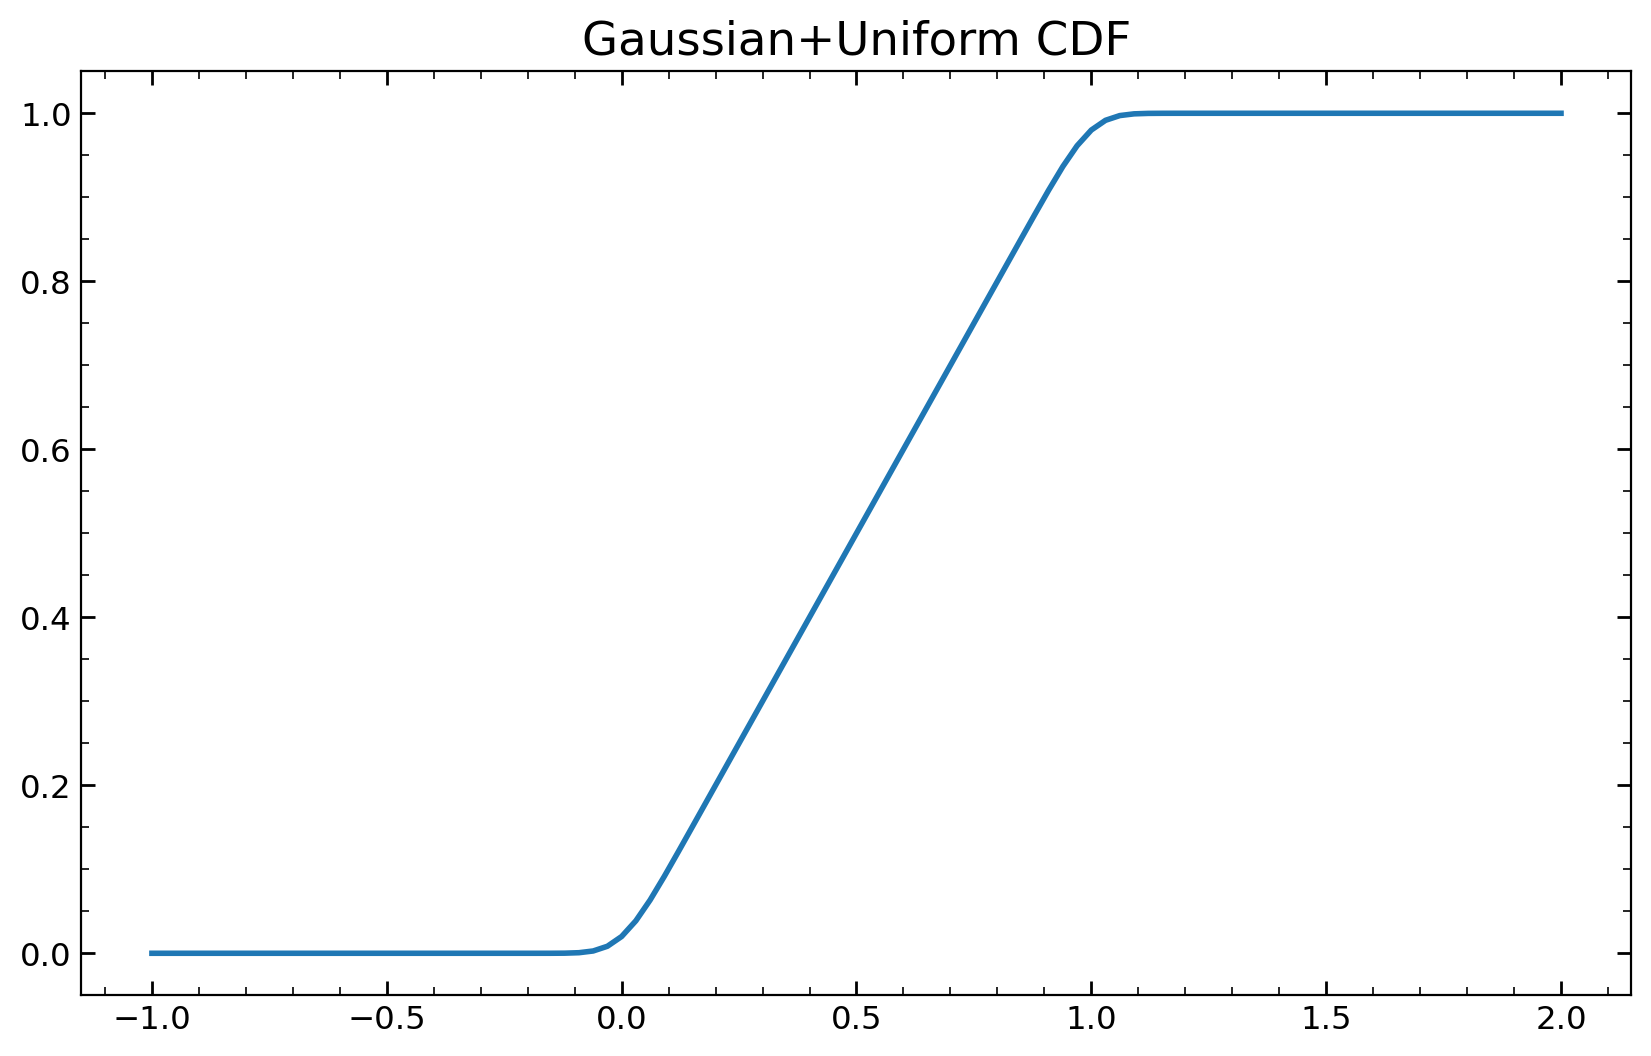

In [ ]:
import numpy as np
from scipy.stats import norm


def smooth_uniform_cdf(x, a=0.0, b=1.0, sigma=0.05):
    x = np.asarray(x)
    z1 = (x - a) / sigma
    z2 = (x - b) / sigma

    phi_z1 = norm.pdf(z1)
    phi_z2 = norm.pdf(z2)
    Phi_z1 = norm.cdf(z1)
    Phi_z2 = norm.cdf(z2)

    cdf = (1 / (b - a)) * (
        (x - a) * Phi_z1 + sigma * phi_z1
        - (x - b) * Phi_z2 - sigma * phi_z2
    )
    return cdf


x = np.linspace(-1, 2, 100)
y = smooth_uniform_cdf(x, a=0., b=1, sigma=0.05)
plt.plot(x, y)
plt.title('Gaussian+Uniform CDF')